In [66]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [67]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [68]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [69]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [70]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [71]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Onehot encoding</h3>

In [72]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [73]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [75]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Discretization with KBinsDiscretizer and Column Transformer</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [76]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [77]:
ct = ColumnTransformer([('k_means_discretizer', 
                         KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'kmeans'),
                        ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
                        'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike'])], 
                       remainder = "drop")

In [78]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3


In [79]:
df_temp = pd.DataFrame(ct.fit_transform(df), columns = columns_to_discretize)
df_temp.head()

,Age,DistanceFromHome,YearsAtCompany,YearsInCurrentRole,NumCompaniesWorked,MonthlyIncome,MonthlyHours,PercentSalaryHike
0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,2.0,0.0,1.0,0.0,0.0,3.0,3.0
3,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3


In [81]:
for column in df_temp:
    if column in df:
        df[column] = df_temp[column]

In [82]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,3.0,0,0,1,0,1.0,4,2,0,3,...,1.0,3,0,2,2,1.0,1.0,1.0,0.39,2
1,1.0,0,0,1,0,0.0,1,2,0,3,...,0.0,3,1,3,3,0.0,1.0,1.0,0.41,2
2,0.0,0,0,0,1,2.0,3,3,0,3,...,3.0,3,1,4,3,0.0,1.0,3.0,0.70,3
3,1.0,0,0,1,0,0.0,4,2,0,3,...,0.0,2,0,1,3,0.0,1.0,2.0,0.84,2
4,1.0,0,0,1,0,1.0,2,3,1,3,...,0.0,3,0,2,3,1.0,0.0,0.0,0.21,3


<h3>Divide into features and target</h3>

In [83]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [84]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5944065706929688
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)

Best k ('n_neighbors'): 7

Plots of the metrics used by the grid search


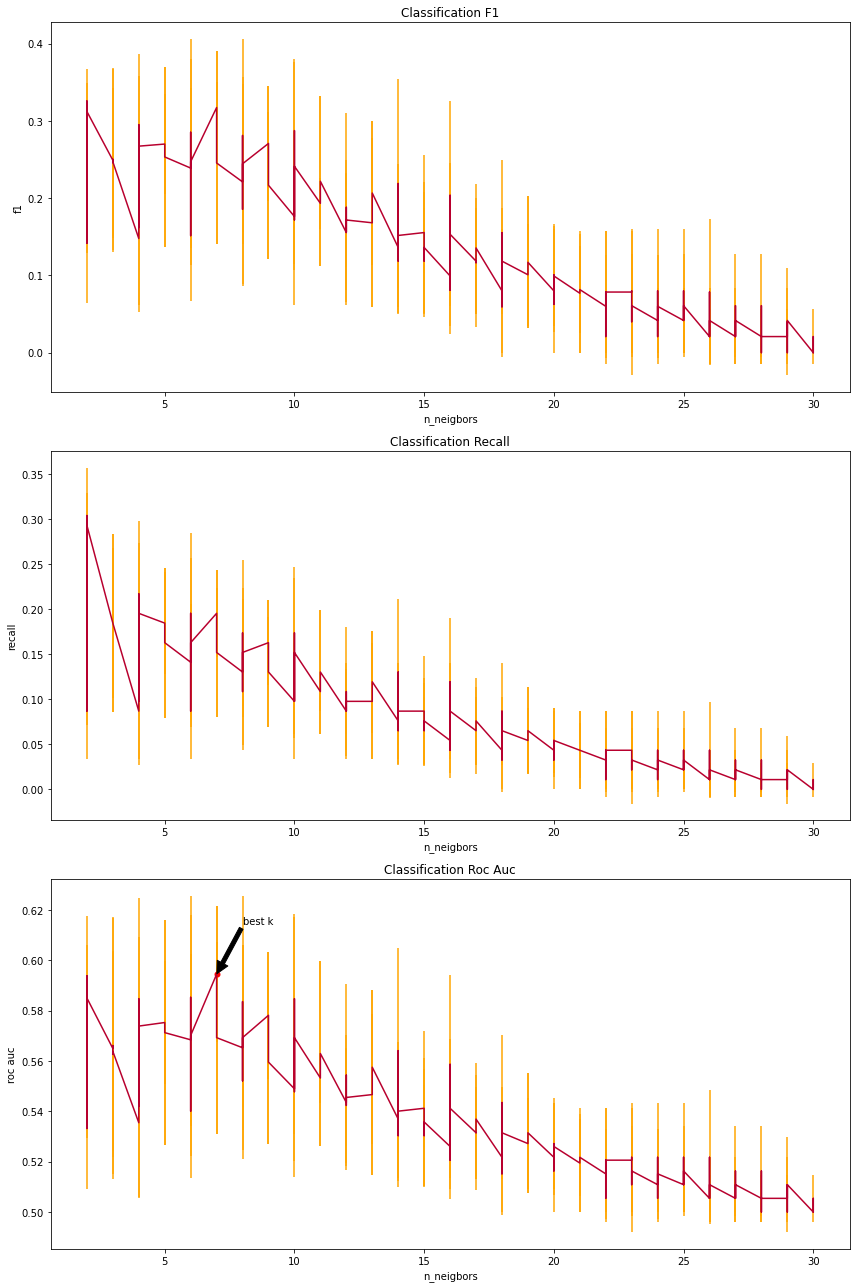



Permutation importances of the training set

JobRole_Laboratory_Technician                      0.022271
OverTime                                           0.017090
EnvironmentSatisfaction                            0.012112
JobRole_Manufacturing_Director                     0.009824
DistanceFromHome                                   0.008172
YearsInCurrentRole                                 0.007154
JobRole_Research_Director                          0.006431
NumCompaniesWorked                                 0.004798
JobRole_Healthcare_Representative                  0.004532
JobRole_Human_Resources                            0.003282
JobRole_Sales_Representative                       0.002888
TrainingTimesLastYear                              0.002666
JobLevel                                           0.002245
JobInvolvement                                     0.002144
JobRole_Manager_Sales                              0.001629
OverallSatisfaction                                0.

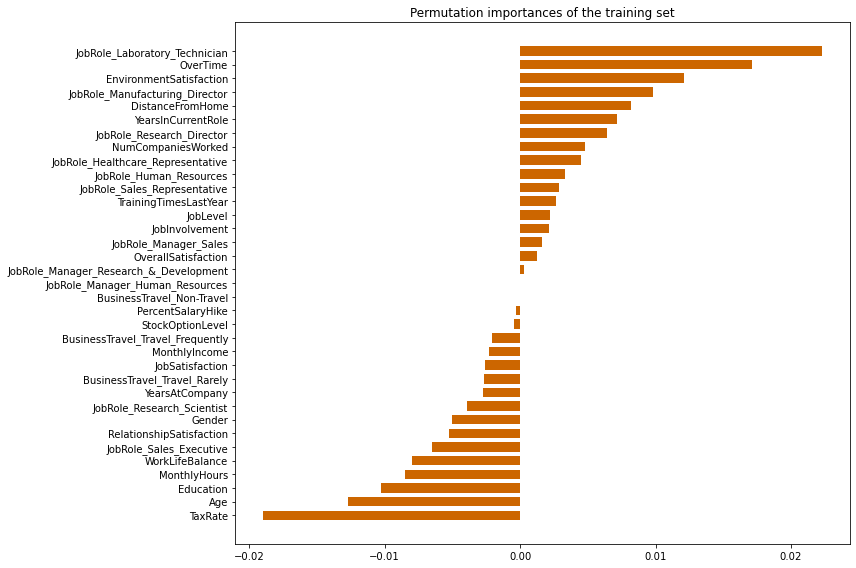



Predictions

Permutation importances of the test set

OverTime                                           0.053710
JobSatisfaction                                    0.045418
StockOptionLevel                                   0.045085
TaxRate                                            0.026744
JobRole_Laboratory_Technician                      0.024601
Age                                                0.022861
DistanceFromHome                                   0.022721
JobRole_Research_Scientist                         0.020581
EnvironmentSatisfaction                            0.018906
YearsInCurrentRole                                 0.018497
OverallSatisfaction                                0.017252
RelationshipSatisfaction                           0.016841
YearsAtCompany                                     0.015188
JobRole_Sales_Executive                            0.014897
JobInvolvement                                     0.013677
Education                                   

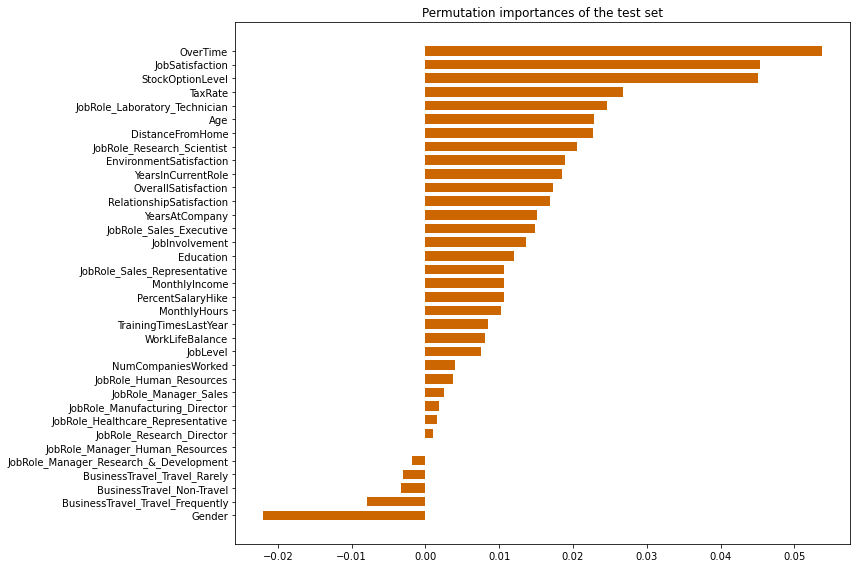



Confusion matrix


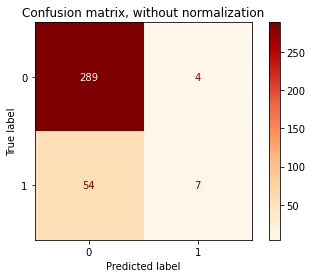

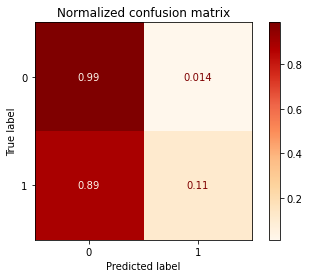


Classification report
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       293
           1       0.64      0.11      0.19        61

    accuracy                           0.84       354
   macro avg       0.74      0.55      0.55       354
weighted avg       0.81      0.84      0.79       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90880503 0.19444444]
Precision [0.8425656  0.63636364]
Recall [0.98634812 0.1147541 ]
Roc_auc 0.5505511106137749


Roc curve



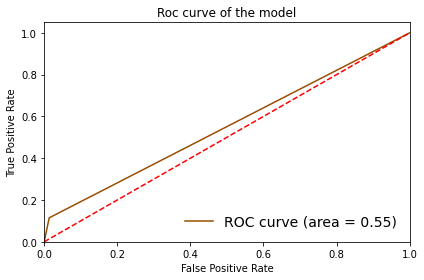


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5837177848512125
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


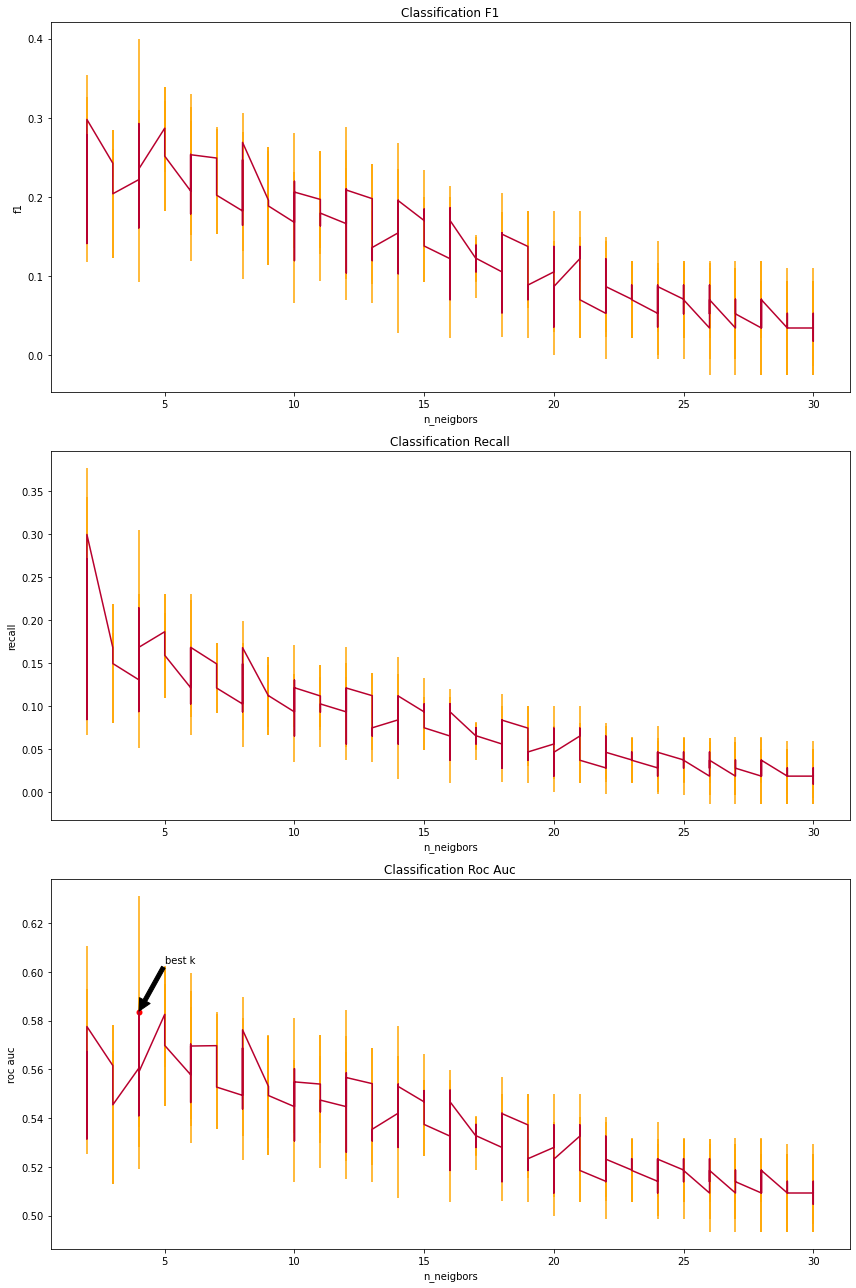



Permutation importances of the training set

OverTime                                           0.000013
Gender                                             0.000007
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.

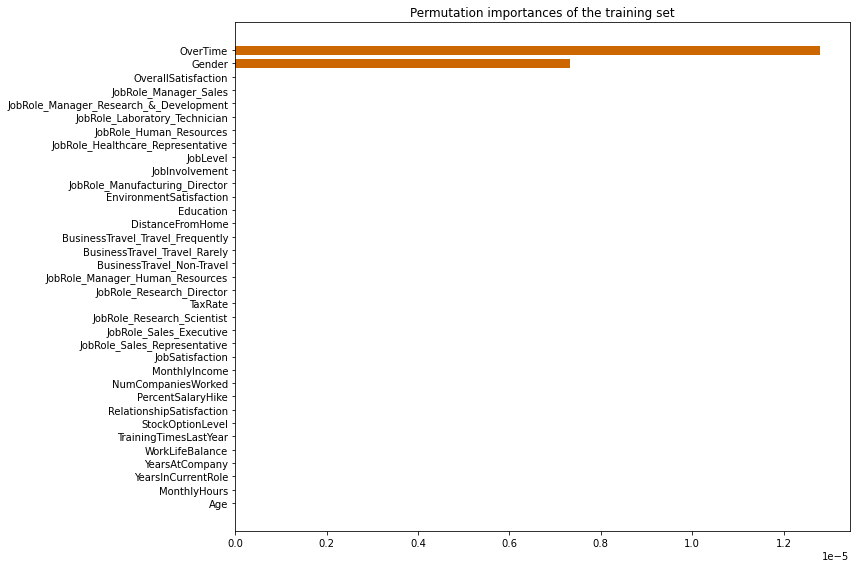



Predictions

Permutation importances of the test set

OverTime                                           0.053583
JobInvolvement                                     0.031100
JobRole_Sales_Representative                       0.028851
JobSatisfaction                                    0.017491
JobLevel                                           0.015178
JobRole_Research_Scientist                         0.014701
BusinessTravel_Travel_Frequently                   0.008021
OverallSatisfaction                                0.007311
YearsInCurrentRole                                 0.006755
JobRole_Laboratory_Technician                      0.006581
MonthlyIncome                                      0.006492
JobRole_Manufacturing_Director                     0.005599
WorkLifeBalance                                    0.005594
JobRole_Research_Director                          0.004417
BusinessTravel_Travel_Rarely                       0.003683
JobRole_Manager_Research_&_Development      

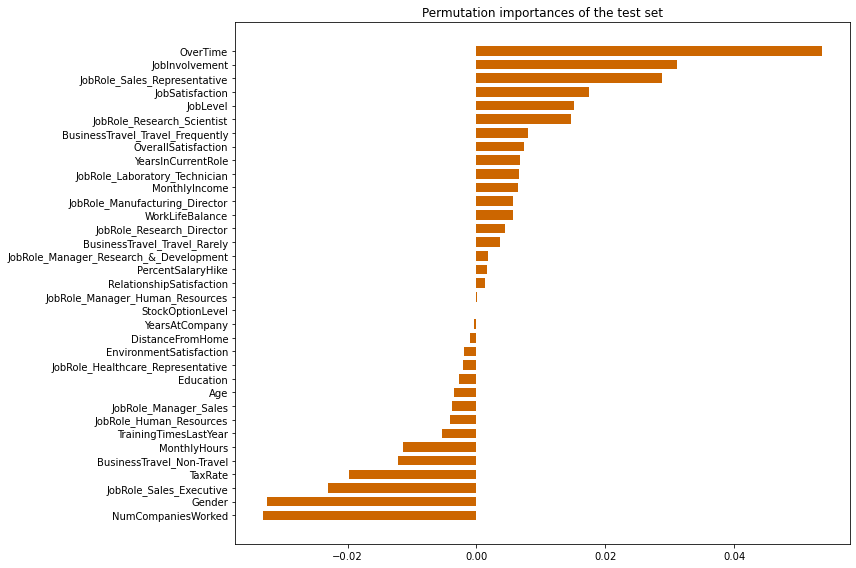



Confusion matrix


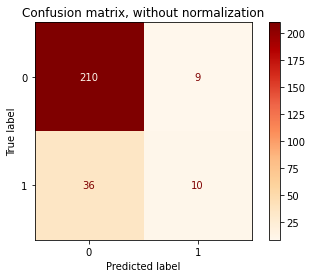

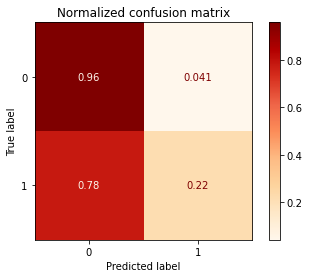


Classification report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       219
           1       0.53      0.22      0.31        46

    accuracy                           0.83       265
   macro avg       0.69      0.59      0.61       265
weighted avg       0.80      0.83      0.80       265


Metrics

Accuracy 0.8301886792452831
F1-score [0.90322581 0.30769231]
Precision [0.85365854 0.52631579]
Recall [0.95890411 0.2173913 ]
Roc_auc 0.5881477069684337


Roc curve



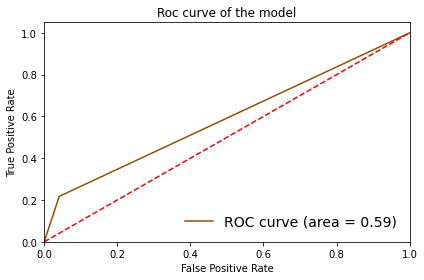


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6096774193548388
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


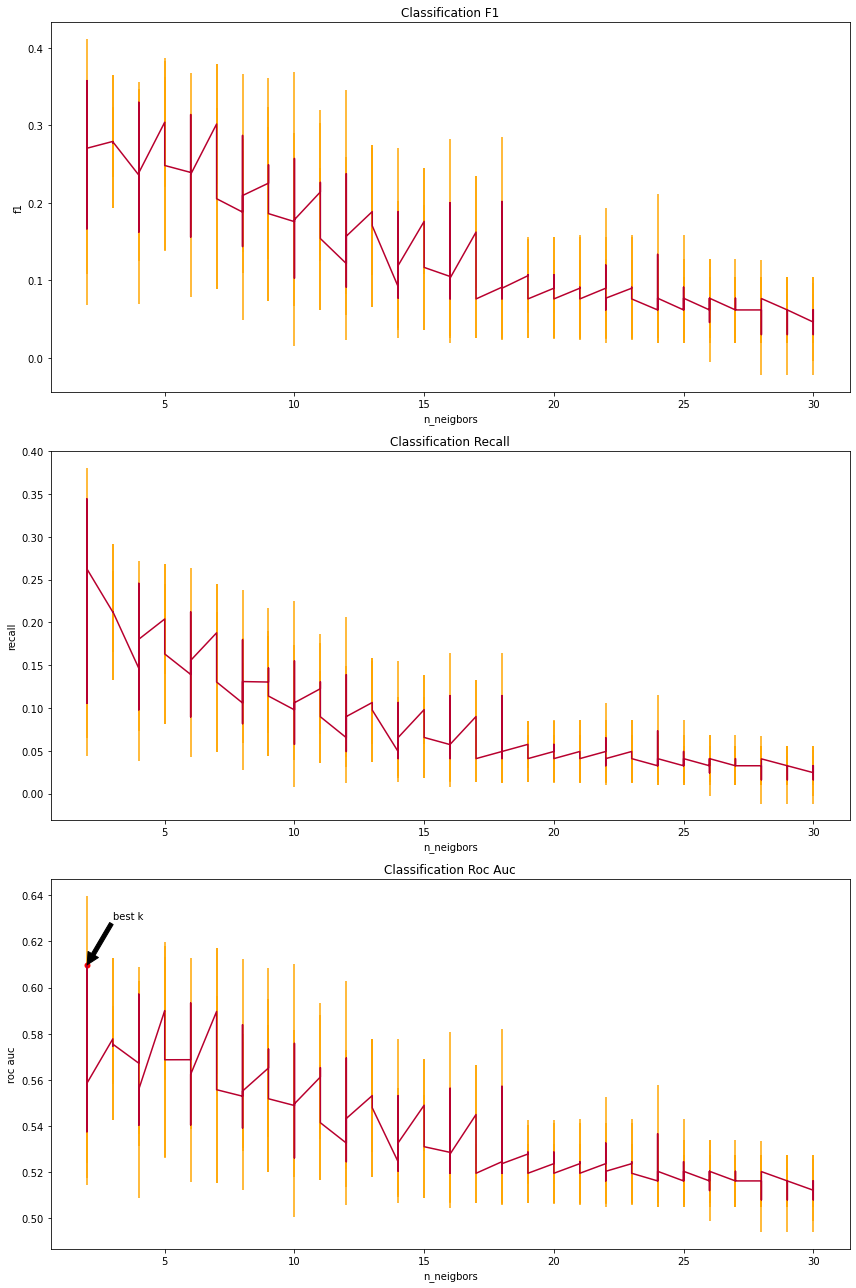



Permutation importances of the training set

DistanceFromHome                                   0.000000
JobRole_Laboratory_Technician                      0.000000
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

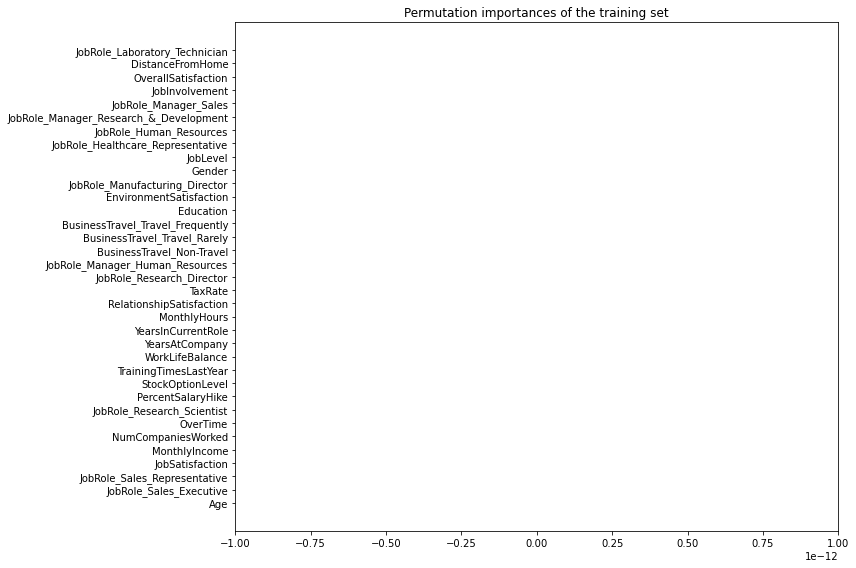



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.049702
OverTime                                           0.045051
JobRole_Research_Scientist                         0.026403
PercentSalaryHike                                  0.024569
JobRole_Manufacturing_Director                     0.018305
OverallSatisfaction                                0.017963
YearsInCurrentRole                                 0.011478
JobLevel                                           0.010705
JobRole_Sales_Executive                            0.009622
WorkLifeBalance                                    0.009280
JobRole_Research_Director                          0.007634
JobRole_Healthcare_Representative                  0.001856
JobRole_Human_Resources                            0.001027
JobRole_Manager_Research_&_Development             0.000199
JobRole_Manager_Human_Resources                    0.000000
BusinessTravel_Travel_Frequently            

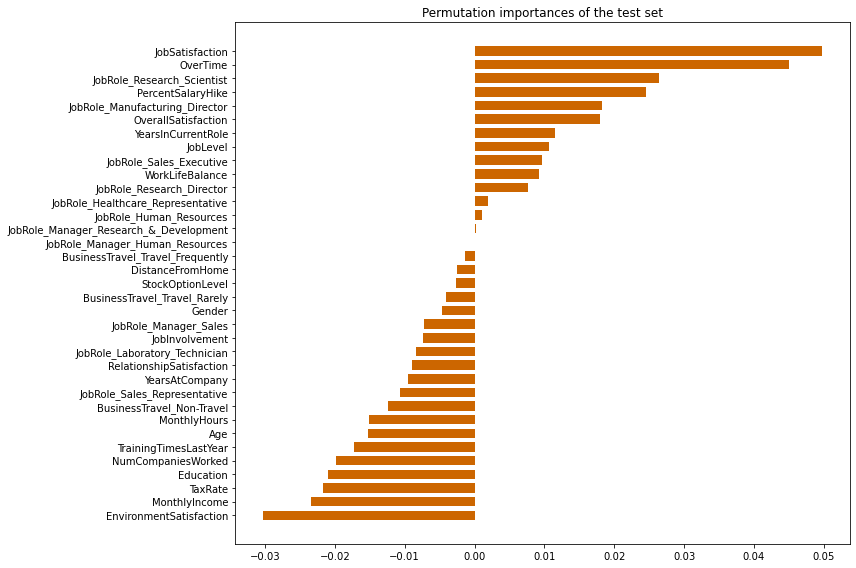



Confusion matrix


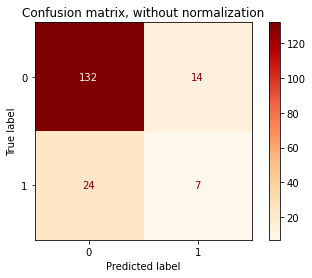

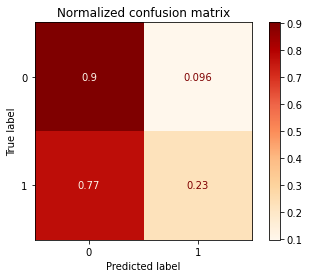


Classification report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       146
           1       0.33      0.23      0.27        31

    accuracy                           0.79       177
   macro avg       0.59      0.56      0.57       177
weighted avg       0.76      0.79      0.77       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.87417219 0.26923077]
Precision [0.84615385 0.33333333]
Recall [0.90410959 0.22580645]
Roc_auc 0.5649580203269996


Roc curve



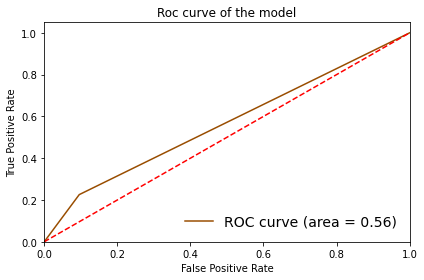


-------------------------------------------------------------------------------------------------------------



In [85]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5938186713565652
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


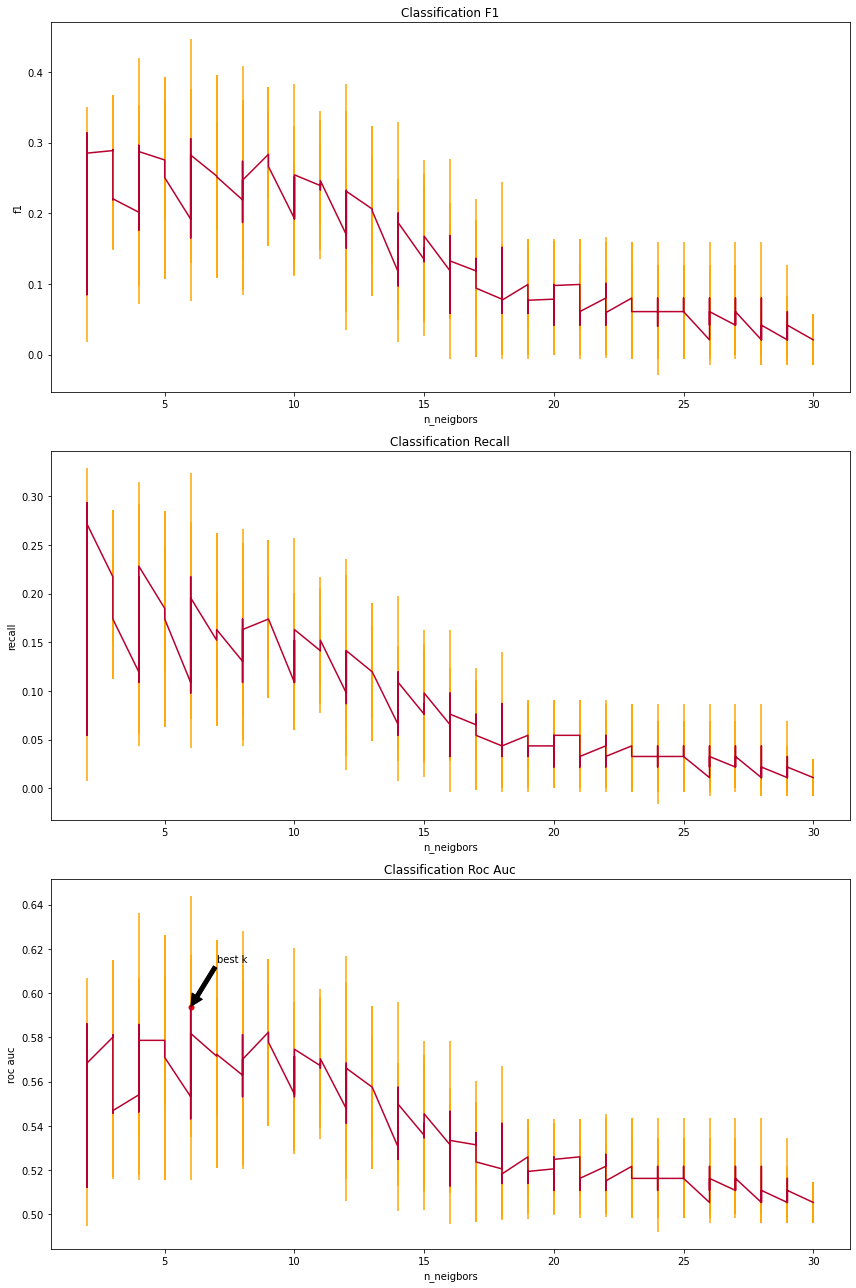



Permutation importances of the training set

OverTime                                           0.000801
Gender                                             0.000052
BusinessTravel_Travel_Rarely                       0.000010
DistanceFromHome                                   0.000010
JobRole_Research_Scientist                         0.000007
StockOptionLevel                                   0.000005
TaxRate                                            0.000005
BusinessTravel_Non-Travel                          0.000002
Age                                                0.000000
BusinessTravel_Travel_Frequently                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.

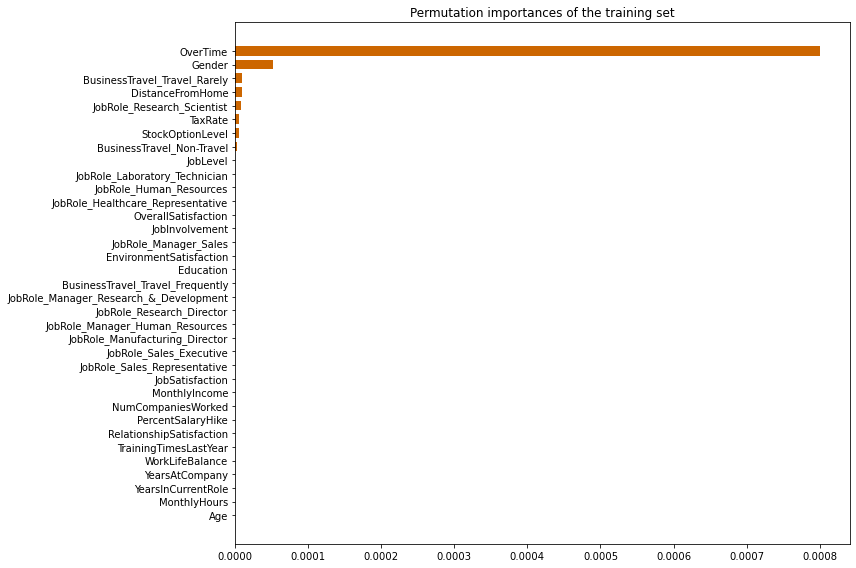



Predictions

Permutation importances of the test set

OverTime                                           0.062751
StockOptionLevel                                   0.033688
JobSatisfaction                                    0.024705
YearsInCurrentRole                                 0.022235
Age                                                0.018315
WorkLifeBalance                                    0.015045
JobRole_Sales_Representative                       0.014900
JobLevel                                           0.013996
JobRole_Research_Scientist                         0.013719
YearsAtCompany                                     0.013677
EnvironmentSatisfaction                            0.012709
JobRole_Manufacturing_Director                     0.010575
OverallSatisfaction                                0.010200
RelationshipSatisfaction                           0.009836
PercentSalaryHike                                  0.009506
JobRole_Sales_Executive                     

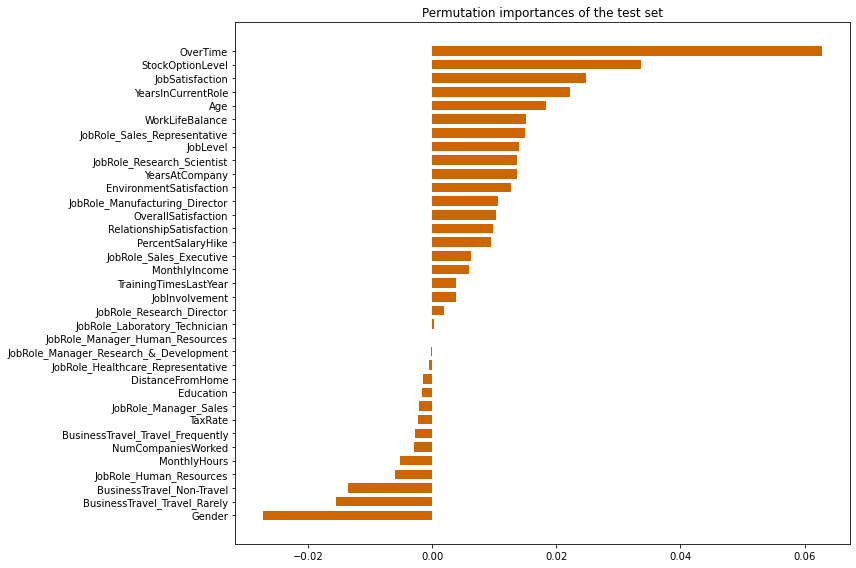



Confusion matrix


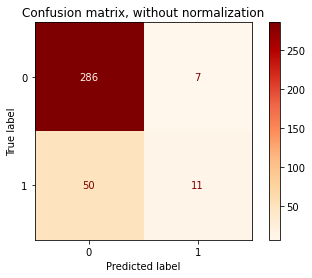

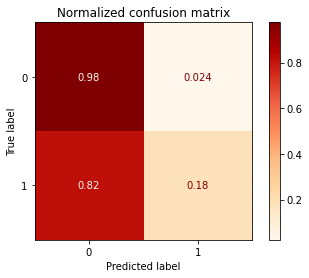


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.61      0.18      0.28        61

    accuracy                           0.84       354
   macro avg       0.73      0.58      0.59       354
weighted avg       0.81      0.84      0.80       354


Metrics

Accuracy 0.8389830508474576
F1-score [0.90937997 0.27848101]
Precision [0.85119048 0.61111111]
Recall [0.97610922 0.18032787]
Roc_auc 0.5782185419347619


Roc curve



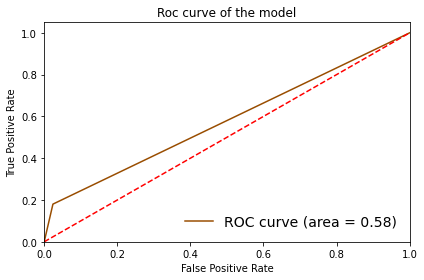


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5790799618847724
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


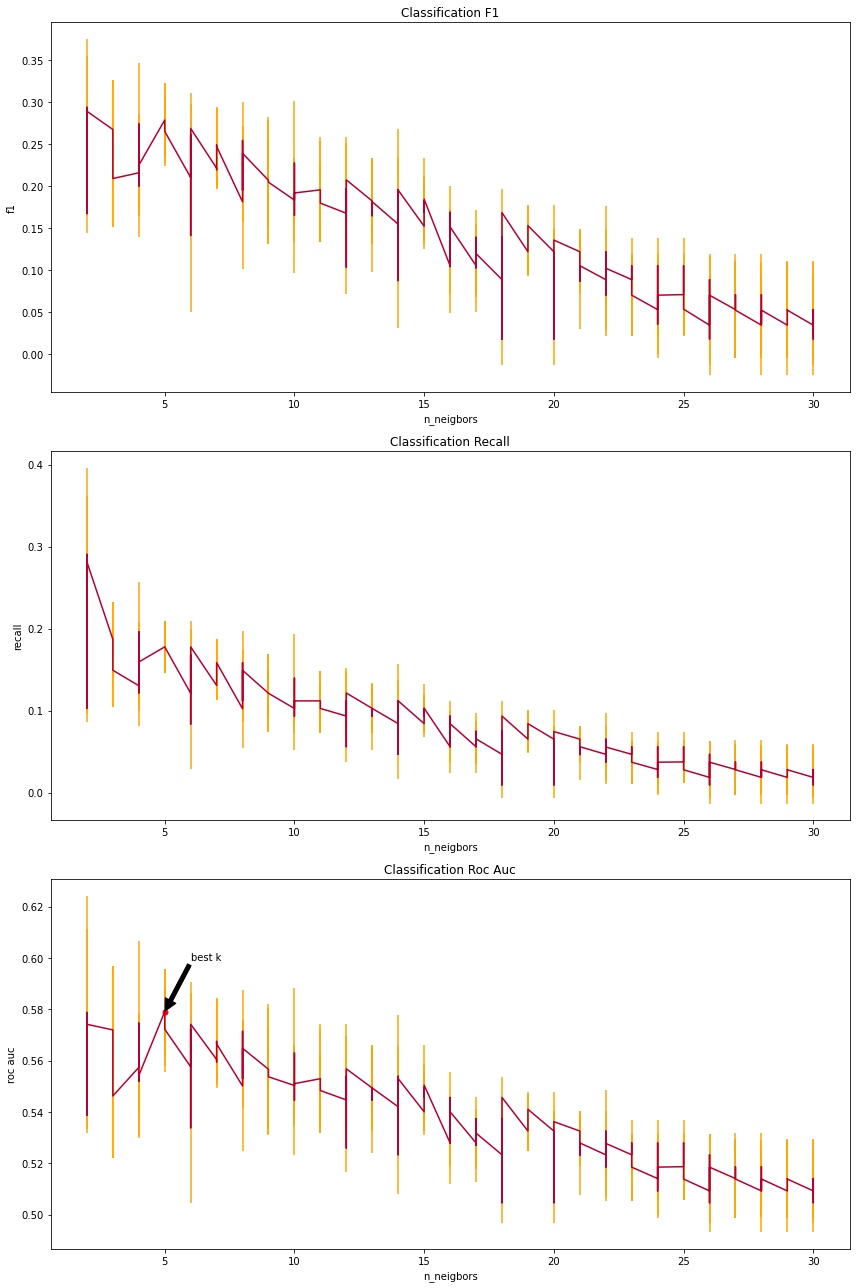



Permutation importances of the training set

OverTime                                           0.030774
StockOptionLevel                                   0.013884
JobRole_Laboratory_Technician                      0.009583
JobSatisfaction                                    0.009092
JobRole_Sales_Representative                       0.008804
PercentSalaryHike                                  0.008012
YearsInCurrentRole                                 0.007161
JobRole_Research_Scientist                         0.006610
TrainingTimesLastYear                              0.005190
DistanceFromHome                                   0.004822
JobInvolvement                                     0.003409
MonthlyIncome                                      0.002016
JobRole_Human_Resources                            0.001801
JobRole_Healthcare_Representative                  0.001800
JobRole_Manager_Sales                              0.001691
JobRole_Research_Director                          0.

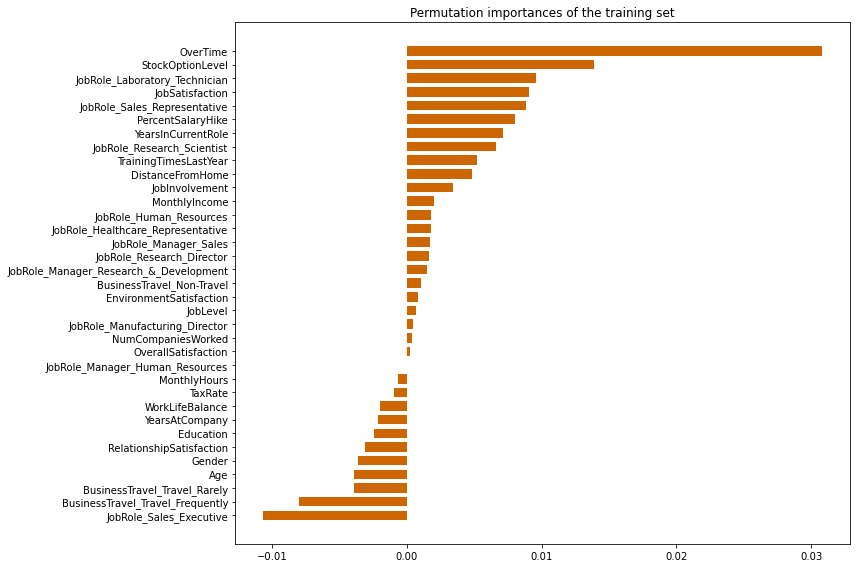



Predictions

Permutation importances of the test set

OverTime                                           0.070811
JobRole_Sales_Representative                       0.042888
OverallSatisfaction                                0.026578
YearsAtCompany                                     0.025744
JobSatisfaction                                    0.022131
JobRole_Research_Scientist                         0.021774
JobLevel                                           0.020022
JobRole_Manufacturing_Director                     0.018538
Age                                                0.011356
WorkLifeBalance                                    0.010681
RelationshipSatisfaction                           0.007202
JobRole_Healthcare_Representative                  0.003842
JobRole_Human_Resources                            0.003271
EnvironmentSatisfaction                            0.002670
YearsInCurrentRole                                 0.002631
JobRole_Research_Director                   

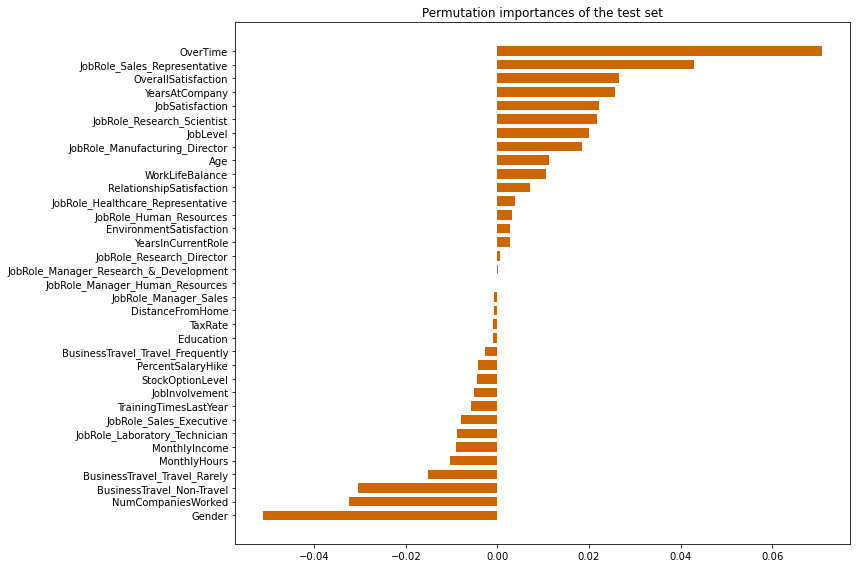



Confusion matrix


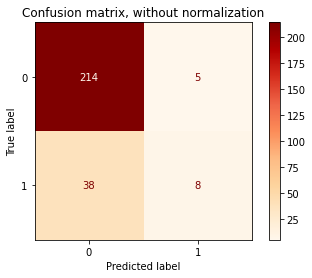

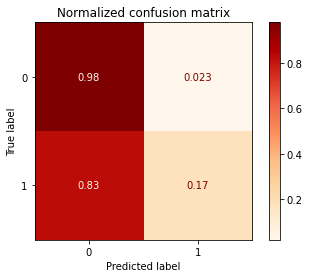


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       219
           1       0.62      0.17      0.27        46

    accuracy                           0.84       265
   macro avg       0.73      0.58      0.59       265
weighted avg       0.81      0.84      0.80       265


Metrics

Accuracy 0.8377358490566038
F1-score [0.90870488 0.27118644]
Precision [0.84920635 0.61538462]
Recall [0.97716895 0.17391304]
Roc_auc 0.5755409966249752


Roc curve



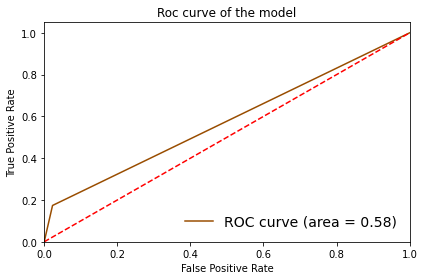


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6095430107526882
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


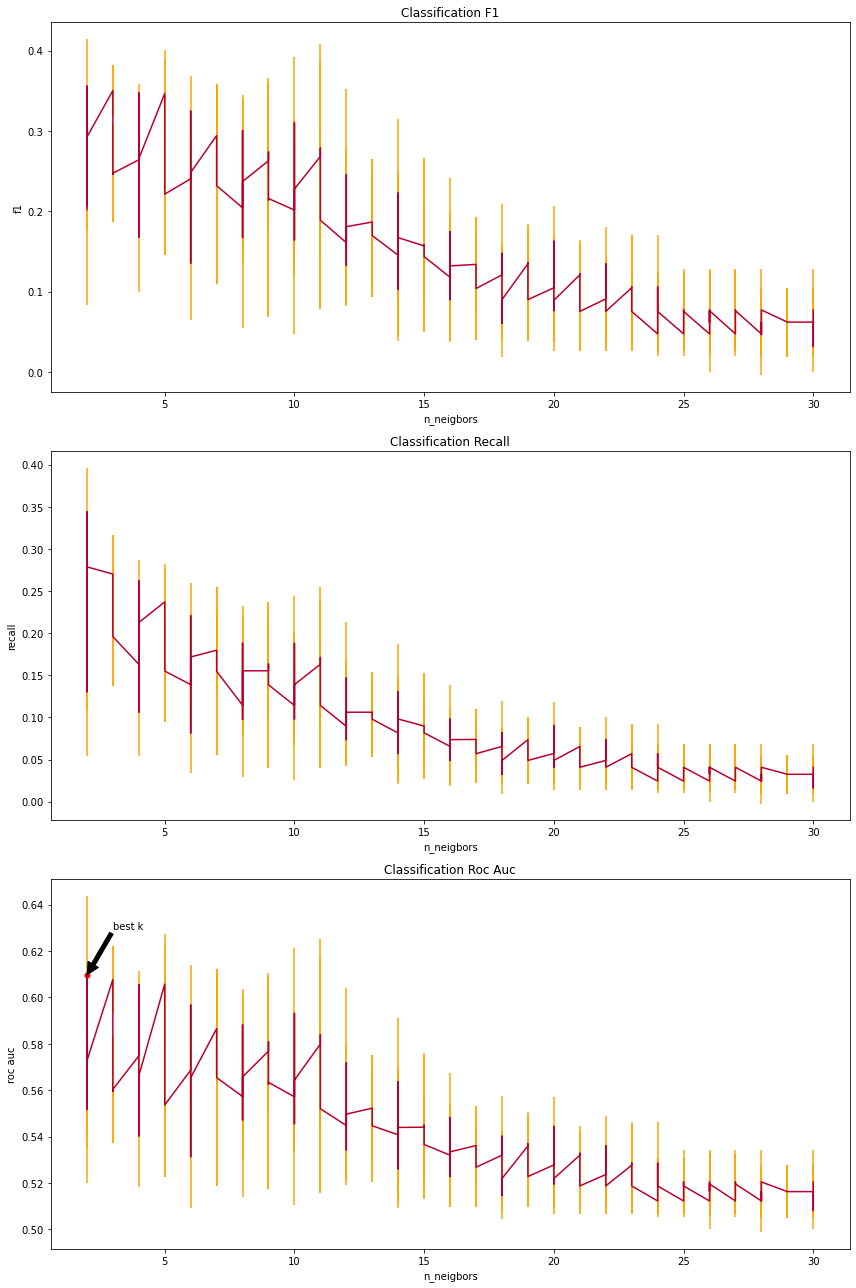



Permutation importances of the training set

Gender                                             0.000000
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

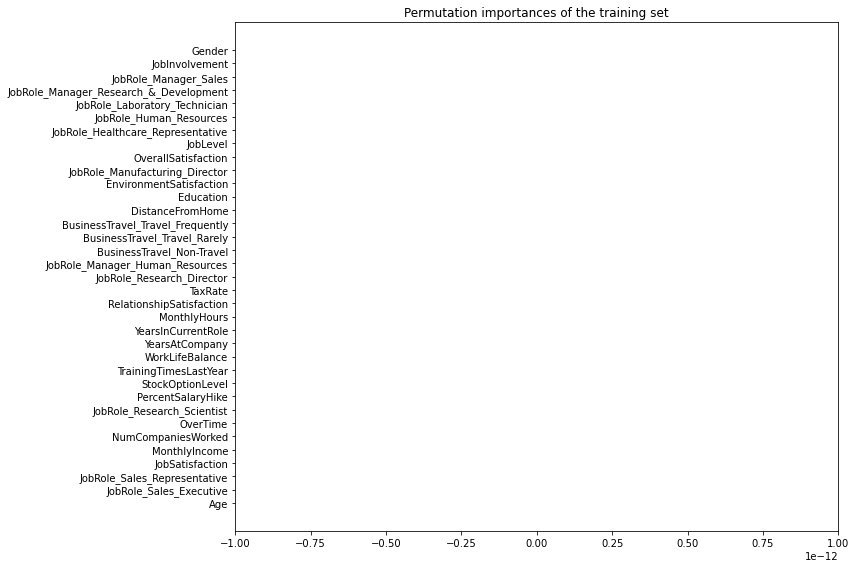



Predictions

Permutation importances of the test set

OverTime                                           0.062384
JobRole_Research_Scientist                         0.044322
JobSatisfaction                                    0.044189
JobLevel                                           0.019819
Education                                          0.017433
JobRole_Manufacturing_Director                     0.016958
OverallSatisfaction                                0.016858
RelationshipSatisfaction                           0.016471
JobRole_Laboratory_Technician                      0.016416
JobRole_Human_Resources                            0.015157
WorkLifeBalance                                    0.013776
DistanceFromHome                                   0.013378
StockOptionLevel                                   0.012152
YearsInCurrentRole                                 0.012152
Age                                                0.008573
PercentSalaryHike                           

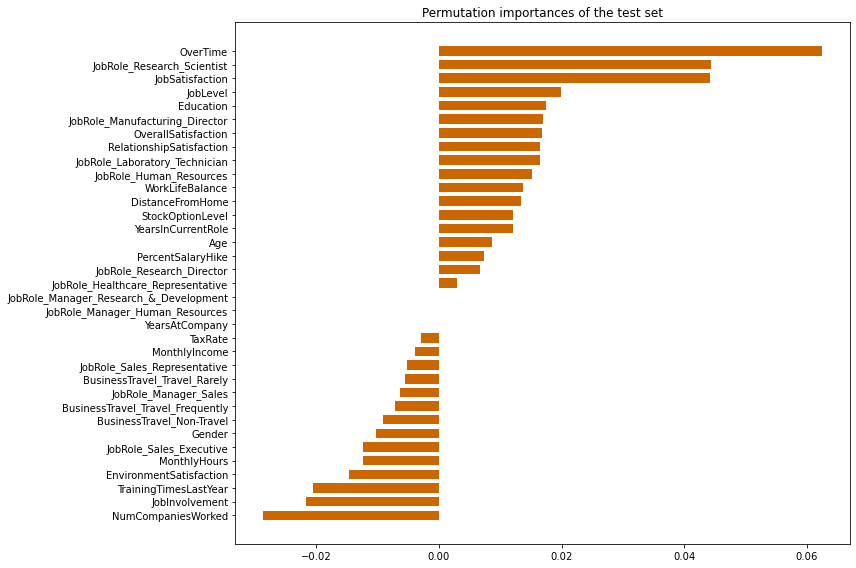



Confusion matrix


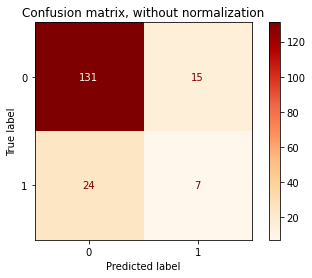

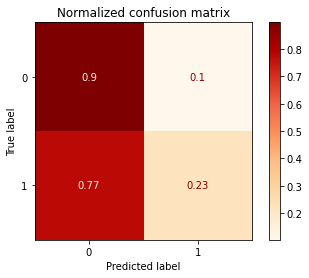


Classification report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       146
           1       0.32      0.23      0.26        31

    accuracy                           0.78       177
   macro avg       0.58      0.56      0.57       177
weighted avg       0.75      0.78      0.76       177


Metrics

Accuracy 0.7796610169491526
F1-score [0.87043189 0.26415094]
Precision [0.84516129 0.31818182]
Recall [0.89726027 0.22580645]
Roc_auc 0.561533362792753


Roc curve



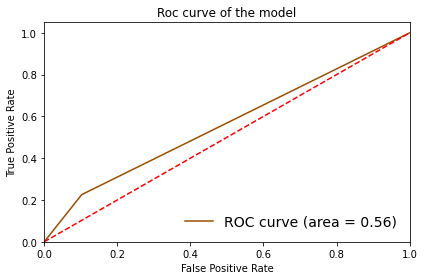


-------------------------------------------------------------------------------------------------------------



In [86]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6106923341915365
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


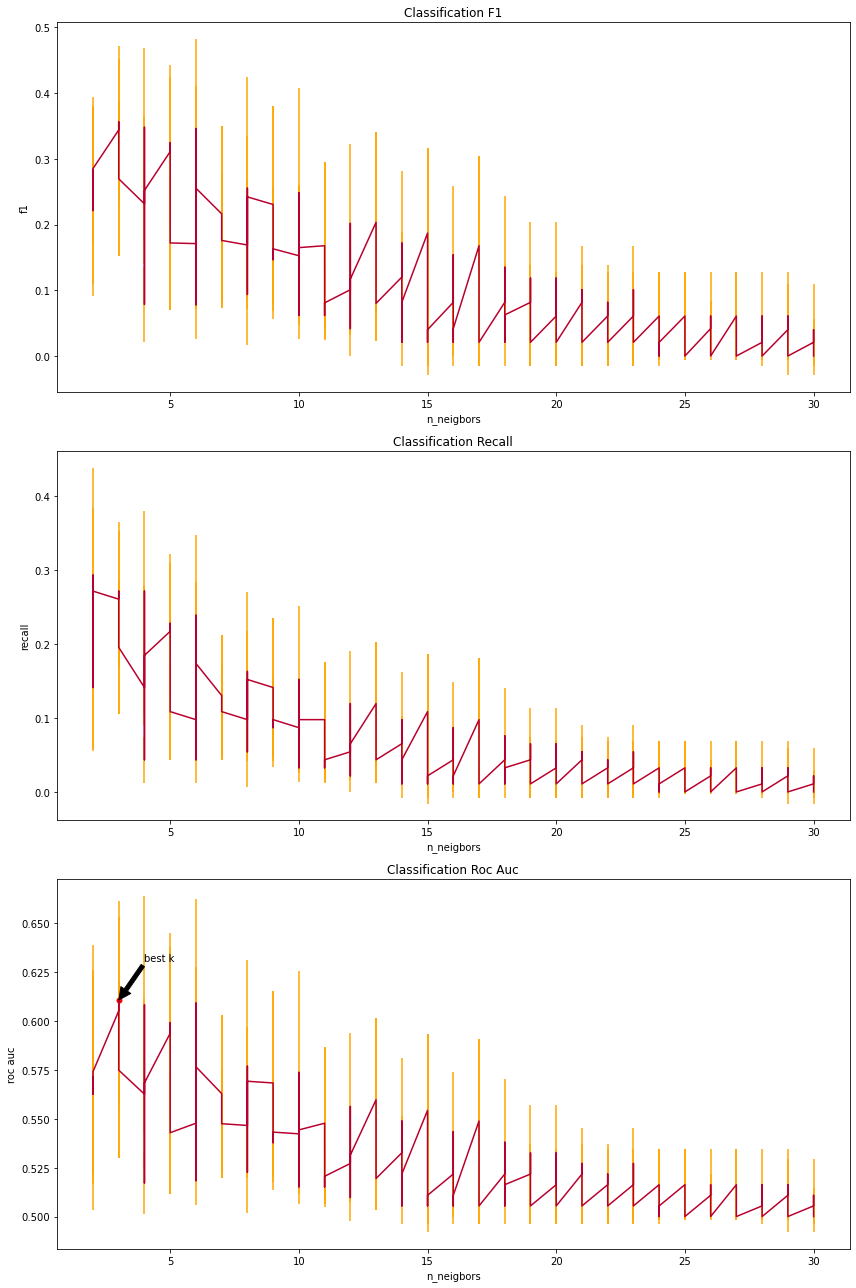



Permutation importances of the training set

TrainingTimesLastYear                              0.000002
WorkLifeBalance                                    0.000000
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.

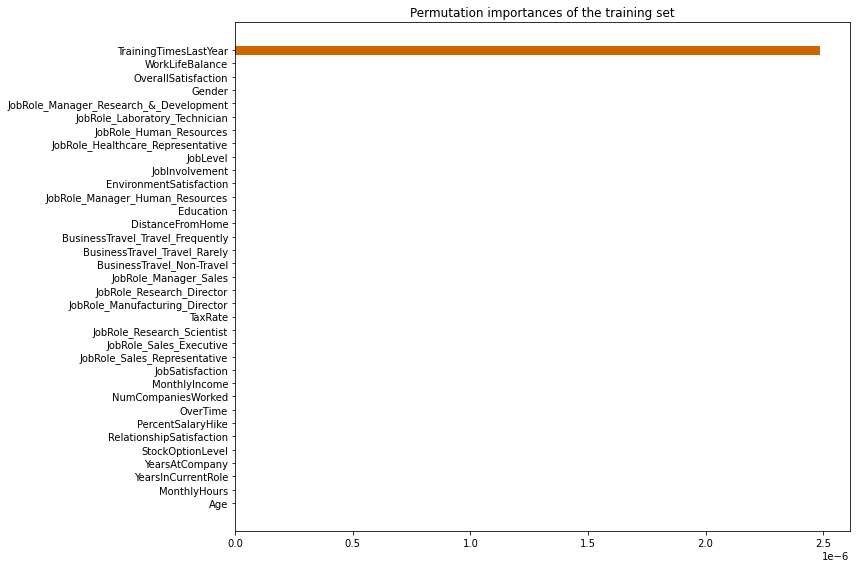



Predictions

Permutation importances of the test set

YearsAtCompany                                     0.037943
OverTime                                           0.030445
JobLevel                                           0.025091
MonthlyIncome                                      0.022626
OverallSatisfaction                                0.020274
JobSatisfaction                                    0.020159
StockOptionLevel                                   0.019809
WorkLifeBalance                                    0.019225
Age                                                0.014676
RelationshipSatisfaction                           0.014323
Gender                                             0.009744
EnvironmentSatisfaction                            0.009307
NumCompaniesWorked                                 0.008846
JobRole_Sales_Representative                       0.008440
JobRole_Sales_Executive                            0.006286
YearsInCurrentRole                          

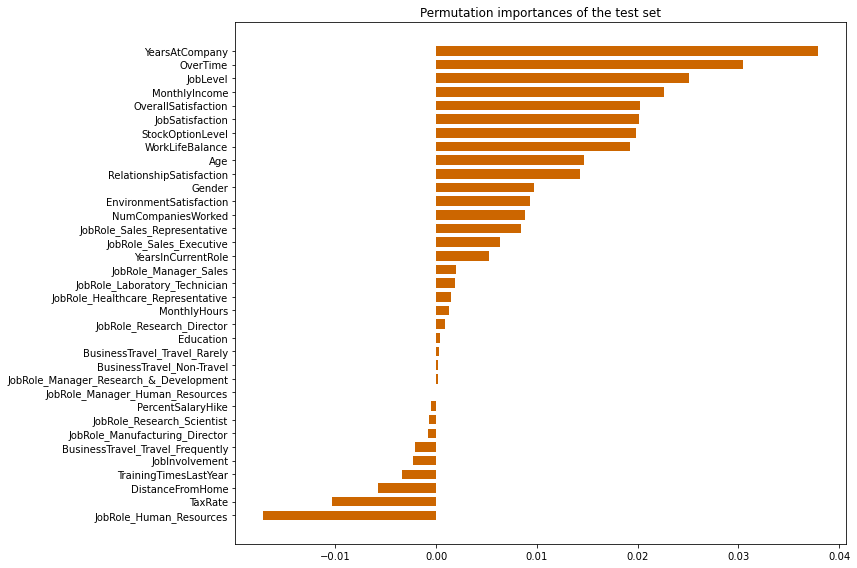



Confusion matrix


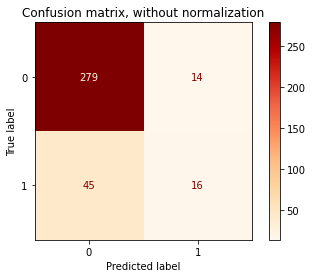

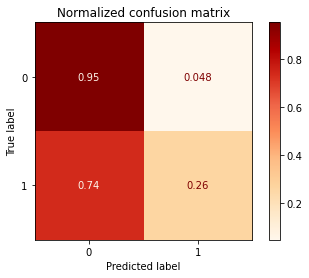


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       293
           1       0.53      0.26      0.35        61

    accuracy                           0.83       354
   macro avg       0.70      0.61      0.63       354
weighted avg       0.80      0.83      0.81       354


Metrics

Accuracy 0.8333333333333334
F1-score [0.90437601 0.35164835]
Precision [0.86111111 0.53333333]
Recall [0.95221843 0.26229508]
Roc_auc 0.6072567560006714


Roc curve



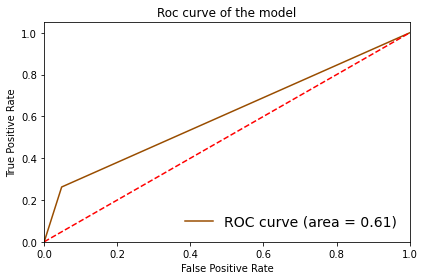


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6072268122434215
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


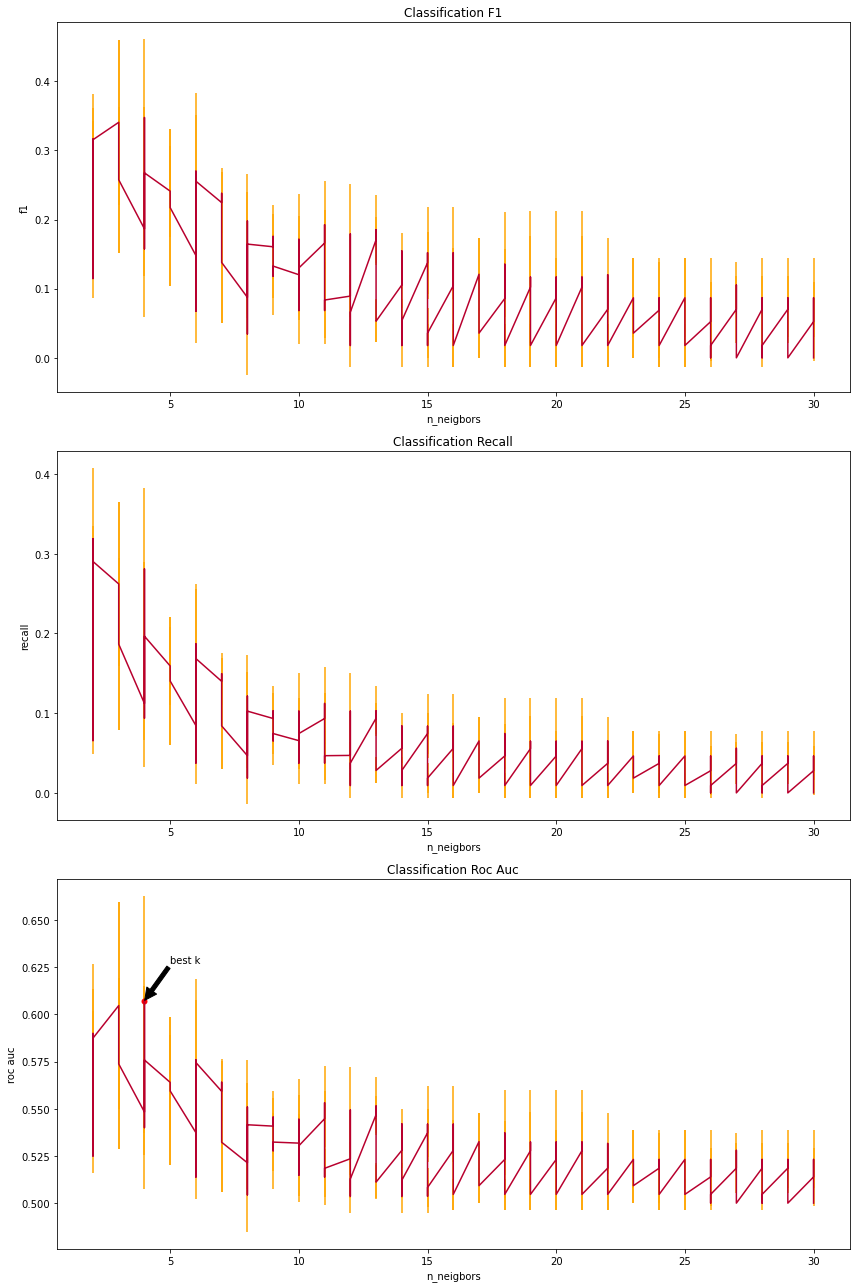



Permutation importances of the training set

TrainingTimesLastYear                              0.000108
StockOptionLevel                                   0.000026
NumCompaniesWorked                                 0.000009
YearsAtCompany                                     0.000004
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.

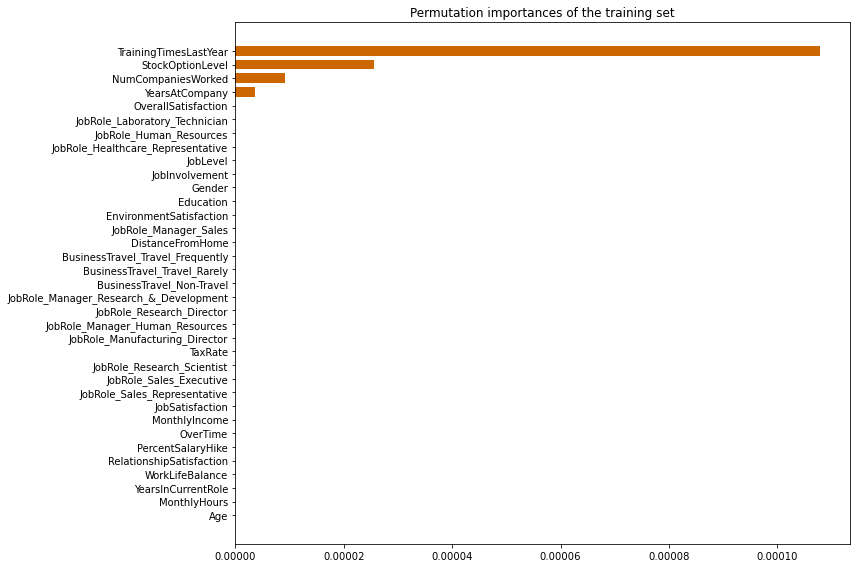



Predictions

Permutation importances of the test set

OverTime                                           0.044282
OverallSatisfaction                                0.032996
JobLevel                                           0.029293
WorkLifeBalance                                    0.026598
BusinessTravel_Travel_Frequently                   0.023253
StockOptionLevel                                   0.020285
JobSatisfaction                                    0.020042
BusinessTravel_Travel_Rarely                       0.014701
Age                                                0.012706
PercentSalaryHike                                  0.007559
RelationshipSatisfaction                           0.007440
JobRole_Sales_Representative                       0.006899
EnvironmentSatisfaction                            0.006859
MonthlyIncome                                      0.005688
TrainingTimesLastYear                              0.003981
MonthlyHours                                

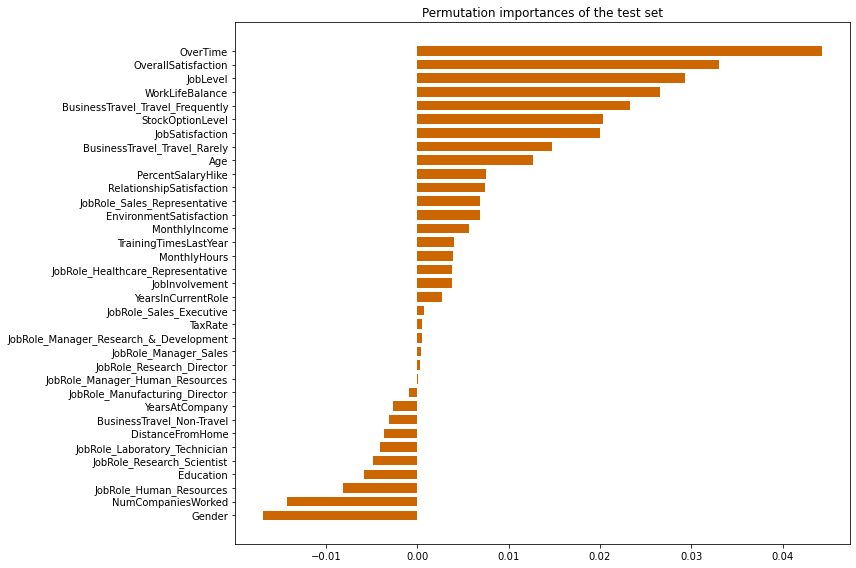



Confusion matrix


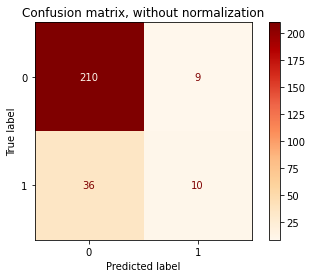

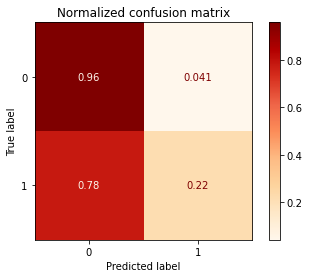


Classification report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       219
           1       0.53      0.22      0.31        46

    accuracy                           0.83       265
   macro avg       0.69      0.59      0.61       265
weighted avg       0.80      0.83      0.80       265


Metrics

Accuracy 0.8301886792452831
F1-score [0.90322581 0.30769231]
Precision [0.85365854 0.52631579]
Recall [0.95890411 0.2173913 ]
Roc_auc 0.5881477069684337


Roc curve



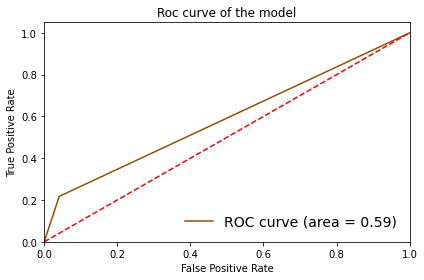


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6250239357784653
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


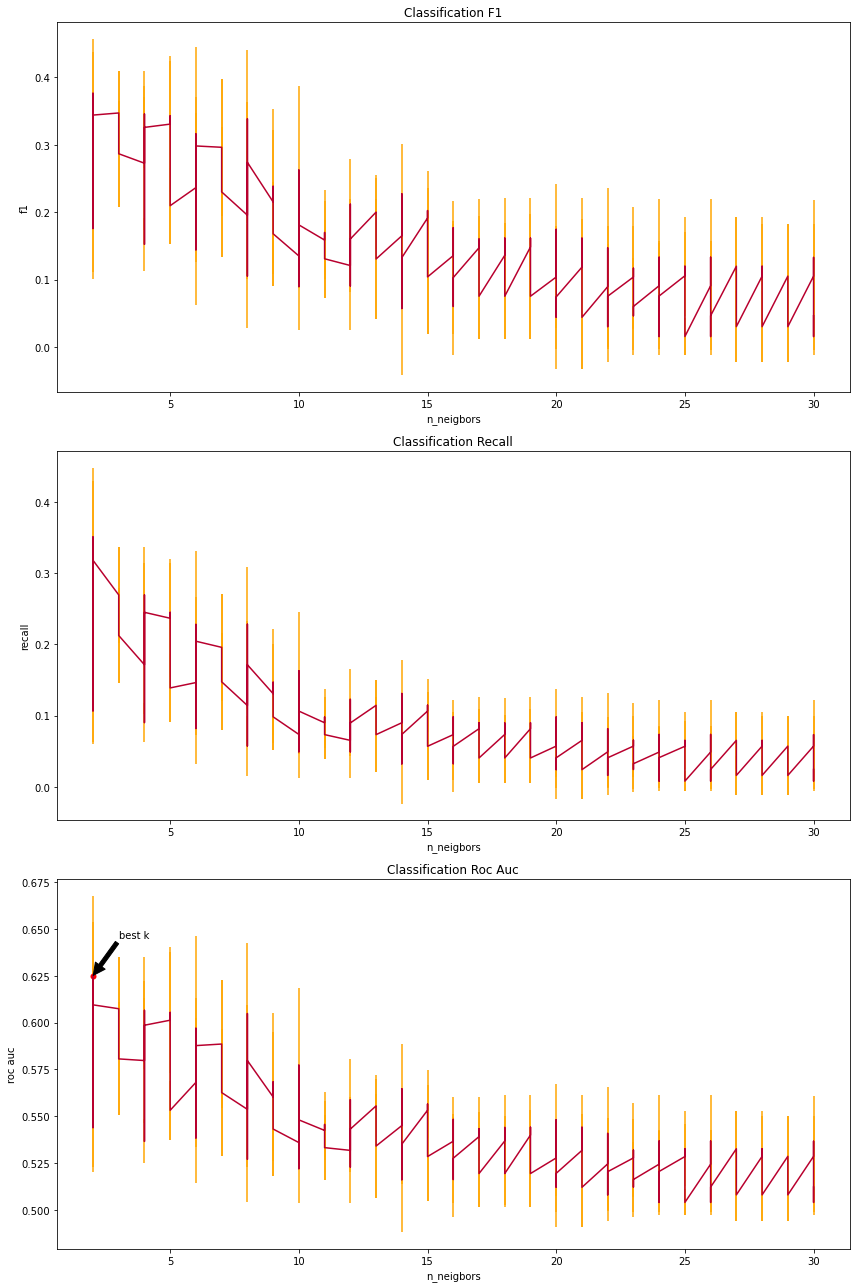



Permutation importances of the training set

Gender                                             0.000000
MonthlyIncome                                      0.000000
OverallSatisfaction                                0.000000
YearsInCurrentRole                                 0.000000
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.

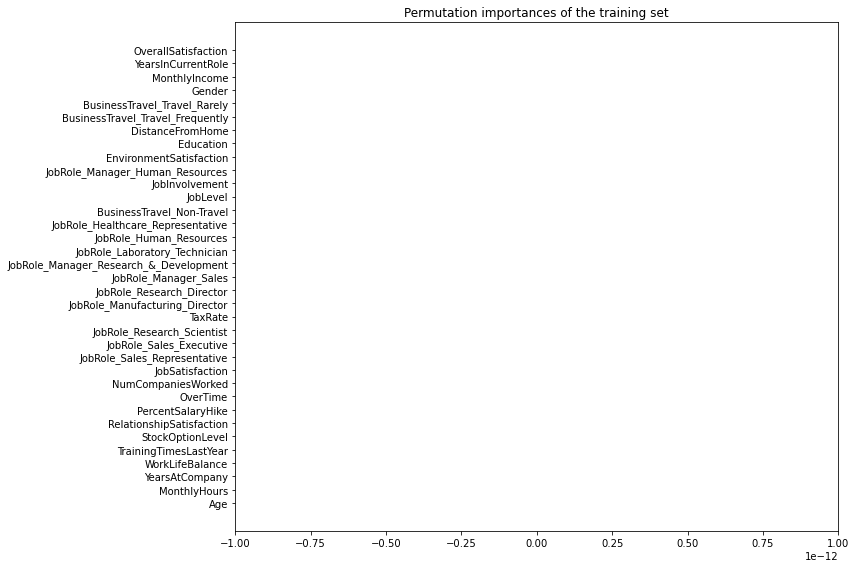



Predictions

Permutation importances of the test set

WorkLifeBalance                                    0.084114
Age                                                0.043493
JobLevel                                           0.037914
OverTime                                           0.035815
RelationshipSatisfaction                           0.032026
OverallSatisfaction                                0.031684
PercentSalaryHike                                  0.026513
BusinessTravel_Travel_Rarely                       0.026436
YearsAtCompany                                     0.024028
JobInvolvement                                     0.024006
Education                                          0.022393
BusinessTravel_Travel_Frequently                   0.021907
JobSatisfaction                                    0.020879
JobRole_Sales_Representative                       0.013522
TrainingTimesLastYear                              0.012550
JobRole_Manufacturing_Director              

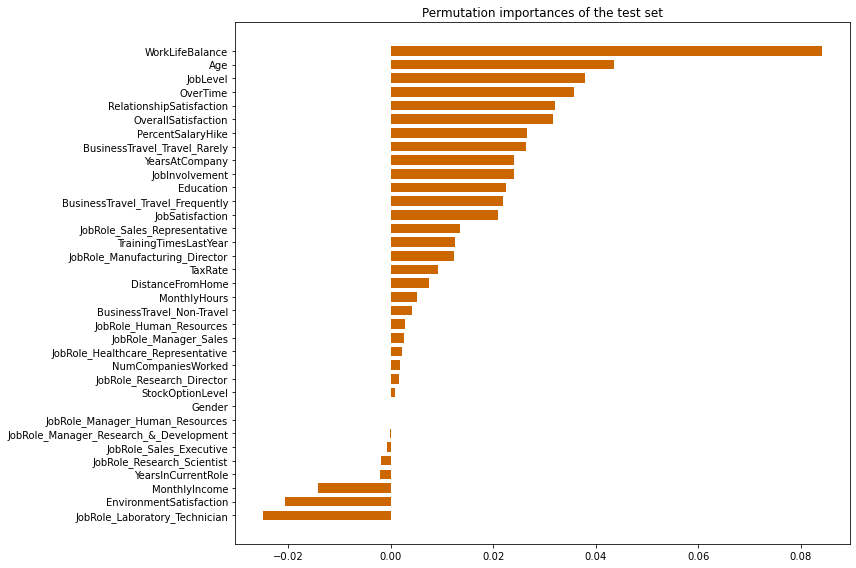



Confusion matrix


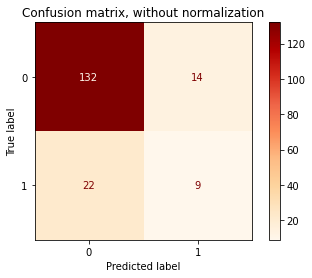

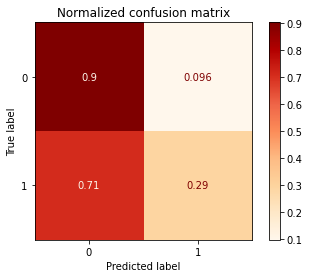


Classification report
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       146
           1       0.39      0.29      0.33        31

    accuracy                           0.80       177
   macro avg       0.62      0.60      0.61       177
weighted avg       0.78      0.80      0.78       177


Metrics

Accuracy 0.7966101694915254
F1-score [0.88       0.33333333]
Precision [0.85714286 0.39130435]
Recall [0.90410959 0.29032258]
Roc_auc 0.5972160848431287


Roc curve



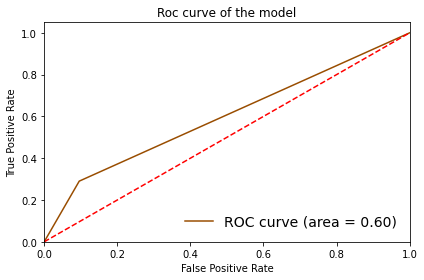


-------------------------------------------------------------------------------------------------------------



In [87]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6158569641367806
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


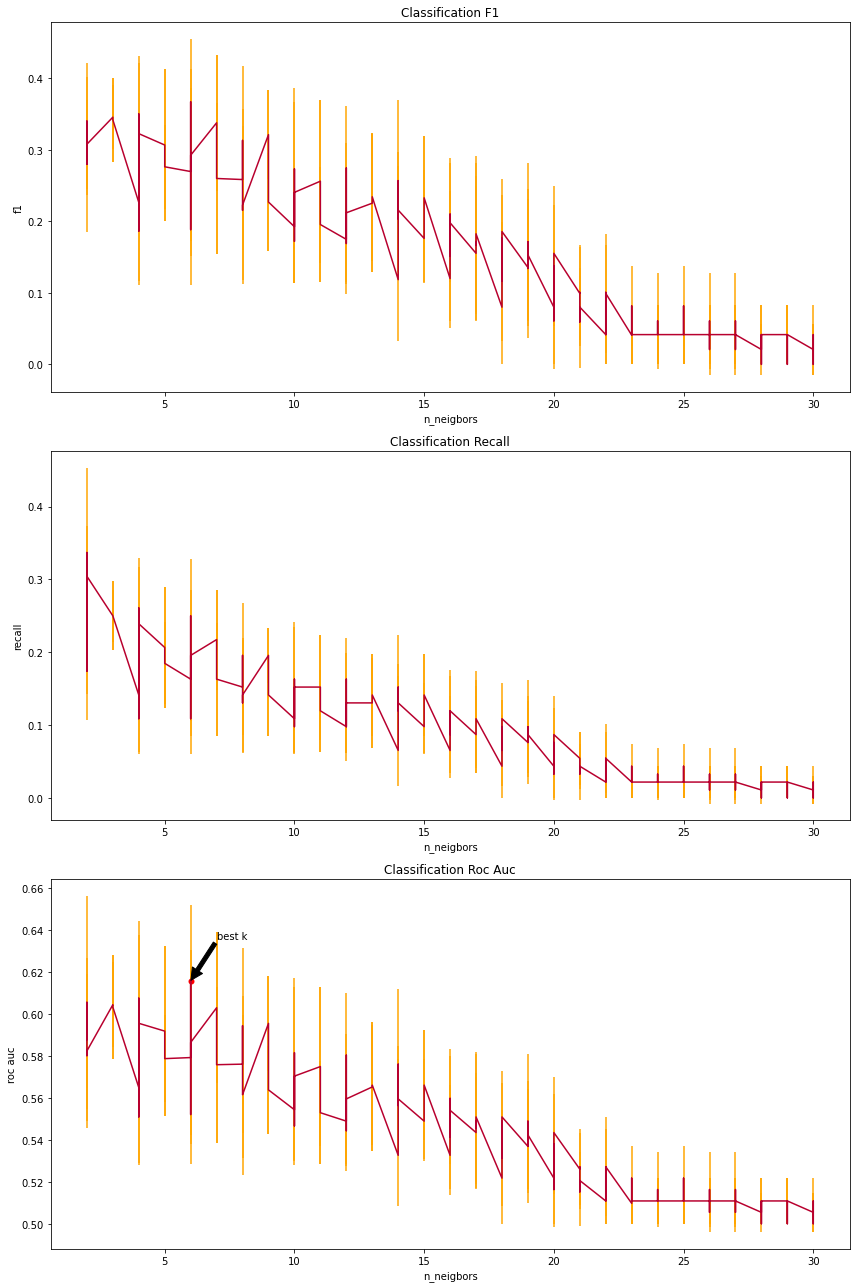



Permutation importances of the training set

JobRole_Sales_Representative                       0.000017
StockOptionLevel                                   0.000010
JobRole_Human_Resources                            0.000002
JobRole_Research_Director                          0.000002
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Laboratory_Technician                      0.

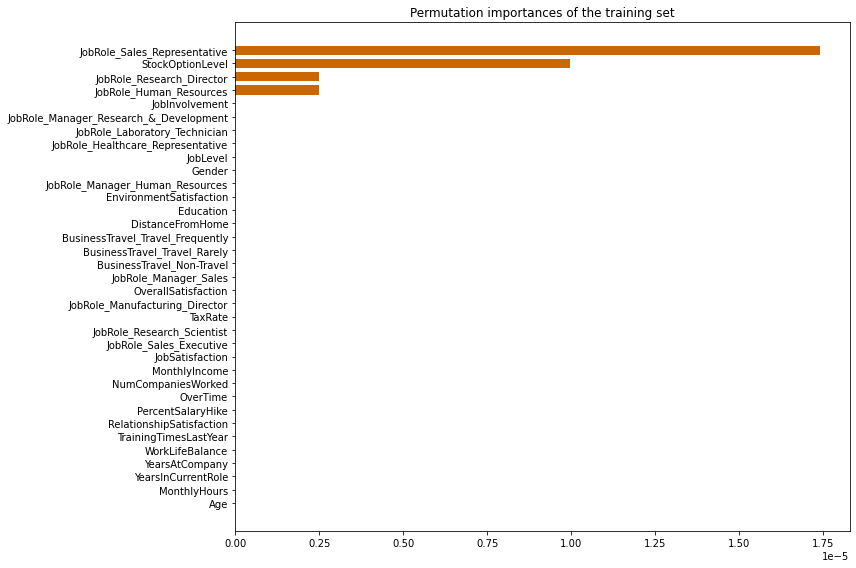



Predictions

Permutation importances of the test set

OverTime                                           0.040041
JobRole_Laboratory_Technician                      0.016768
StockOptionLevel                                   0.015571
WorkLifeBalance                                    0.014718
YearsInCurrentRole                                 0.012068
JobRole_Sales_Representative                       0.009002
Age                                                0.008924
EnvironmentSatisfaction                            0.007612
JobRole_Research_Scientist                         0.006711
NumCompaniesWorked                                 0.006269
OverallSatisfaction                                0.005998
MonthlyIncome                                      0.005866
JobRole_Healthcare_Representative                  0.005452
YearsAtCompany                                     0.004904
TrainingTimesLastYear                              0.004638
JobSatisfaction                             

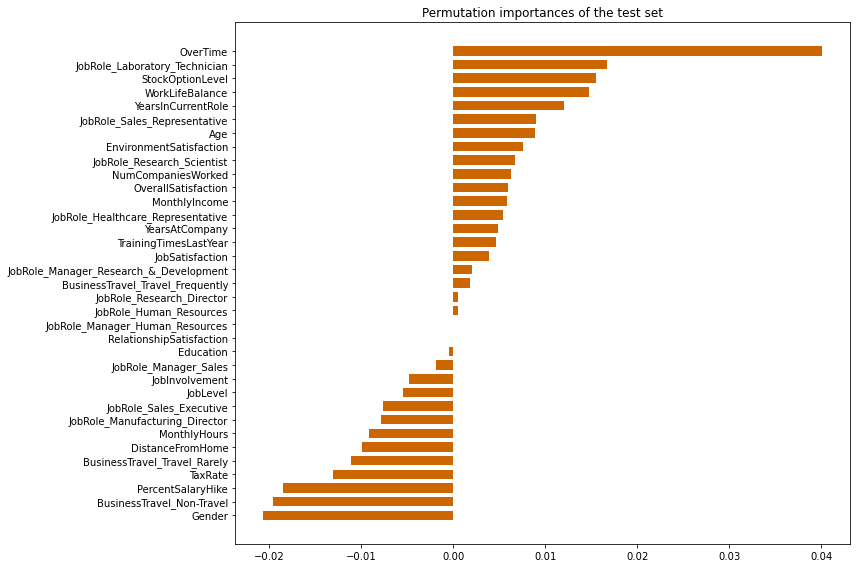



Confusion matrix


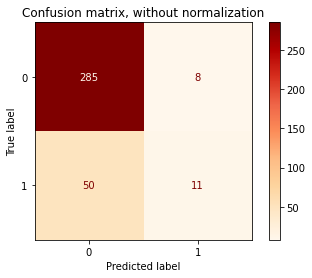

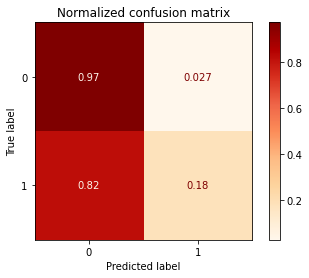


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       293
           1       0.58      0.18      0.28        61

    accuracy                           0.84       354
   macro avg       0.71      0.58      0.59       354
weighted avg       0.80      0.84      0.80       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90764331 0.275     ]
Precision [0.85074627 0.57894737]
Recall [0.97269625 0.18032787]
Roc_auc 0.5765120572931237


Roc curve



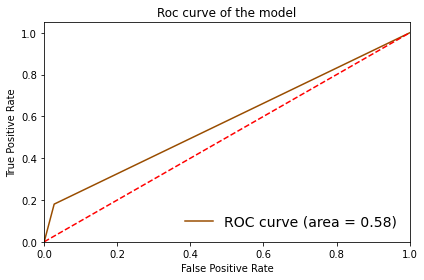


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5862754641897727
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)

Best k ('n_neighbors'): 7

Plots of the metrics used by the grid search


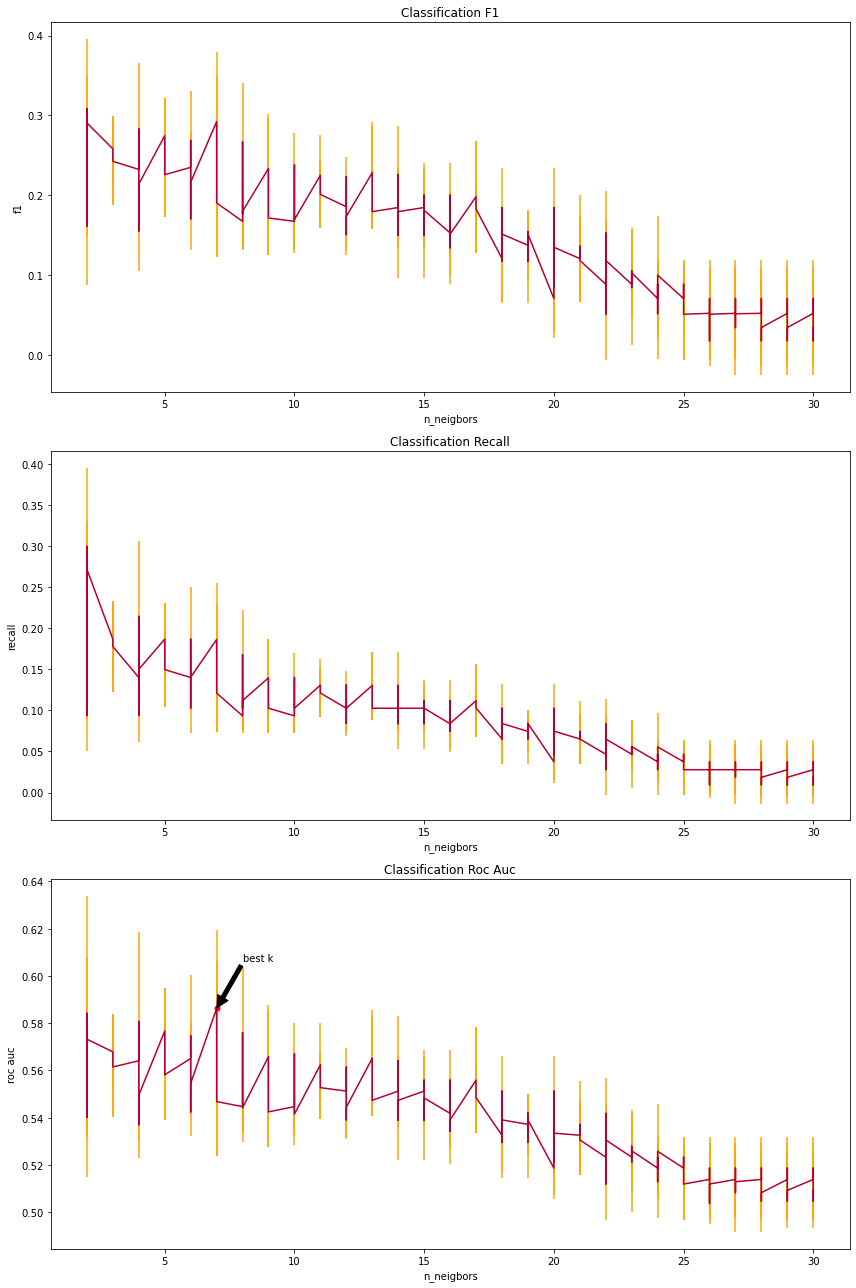



Permutation importances of the training set

OverTime                                           0.018902
StockOptionLevel                                   0.010524
JobRole_Sales_Representative                       0.009384
JobRole_Research_Director                          0.004645
EnvironmentSatisfaction                            0.004560
JobRole_Manufacturing_Director                     0.003889
NumCompaniesWorked                                 0.003512
YearsInCurrentRole                                 0.002567
JobRole_Laboratory_Technician                      0.002141
BusinessTravel_Non-Travel                          0.001675
RelationshipSatisfaction                           0.001491
TrainingTimesLastYear                              0.001441
JobRole_Healthcare_Representative                  0.001416
JobSatisfaction                                    0.000436
JobRole_Manager_Research_&_Development             0.000241
JobRole_Manager_Human_Resources                    -0

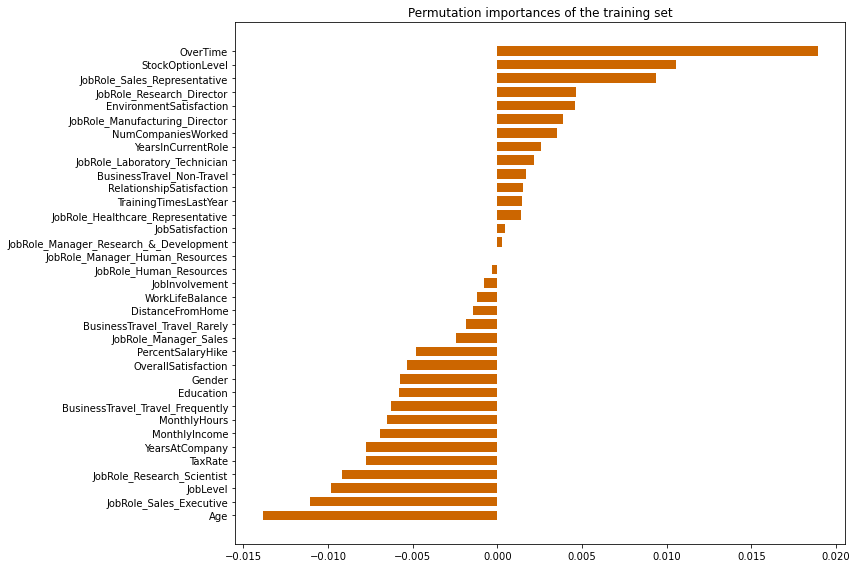



Predictions

Permutation importances of the test set

OverTime                                           0.059227
Age                                                0.033467
WorkLifeBalance                                    0.031805
OverallSatisfaction                                0.024385
JobRole_Laboratory_Technician                      0.022851
JobRole_Research_Scientist                         0.022533
StockOptionLevel                                   0.016021
JobRole_Human_Resources                            0.015947
YearsInCurrentRole                                 0.014845
NumCompaniesWorked                                 0.012150
JobRole_Healthcare_Representative                  0.010239
JobSatisfaction                                    0.009877
EnvironmentSatisfaction                            0.009157
TrainingTimesLastYear                              0.007763
Education                                          0.007738
JobRole_Manufacturing_Director              

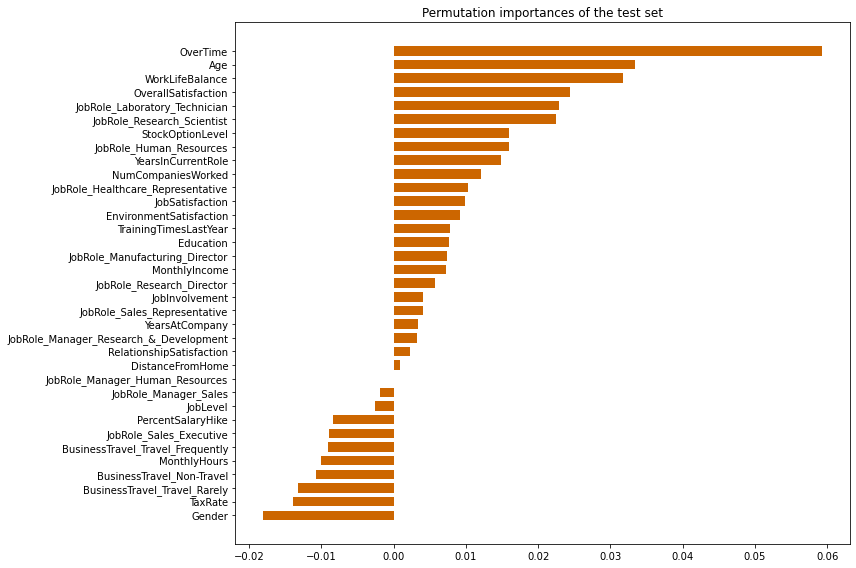



Confusion matrix


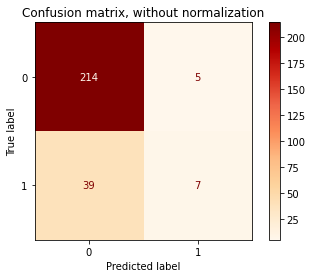

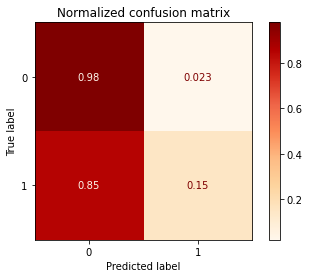


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       219
           1       0.58      0.15      0.24        46

    accuracy                           0.83       265
   macro avg       0.71      0.56      0.57       265
weighted avg       0.80      0.83      0.79       265


Metrics

Accuracy 0.8339622641509434
F1-score [0.90677966 0.24137931]
Precision [0.8458498  0.58333333]
Recall [0.97716895 0.15217391]
Roc_auc 0.5646714314075839


Roc curve



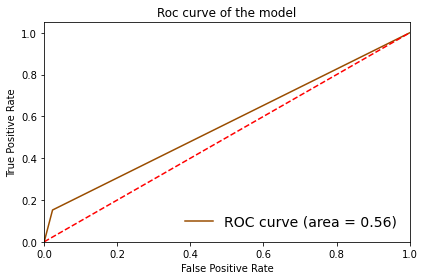


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6115241567241125
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


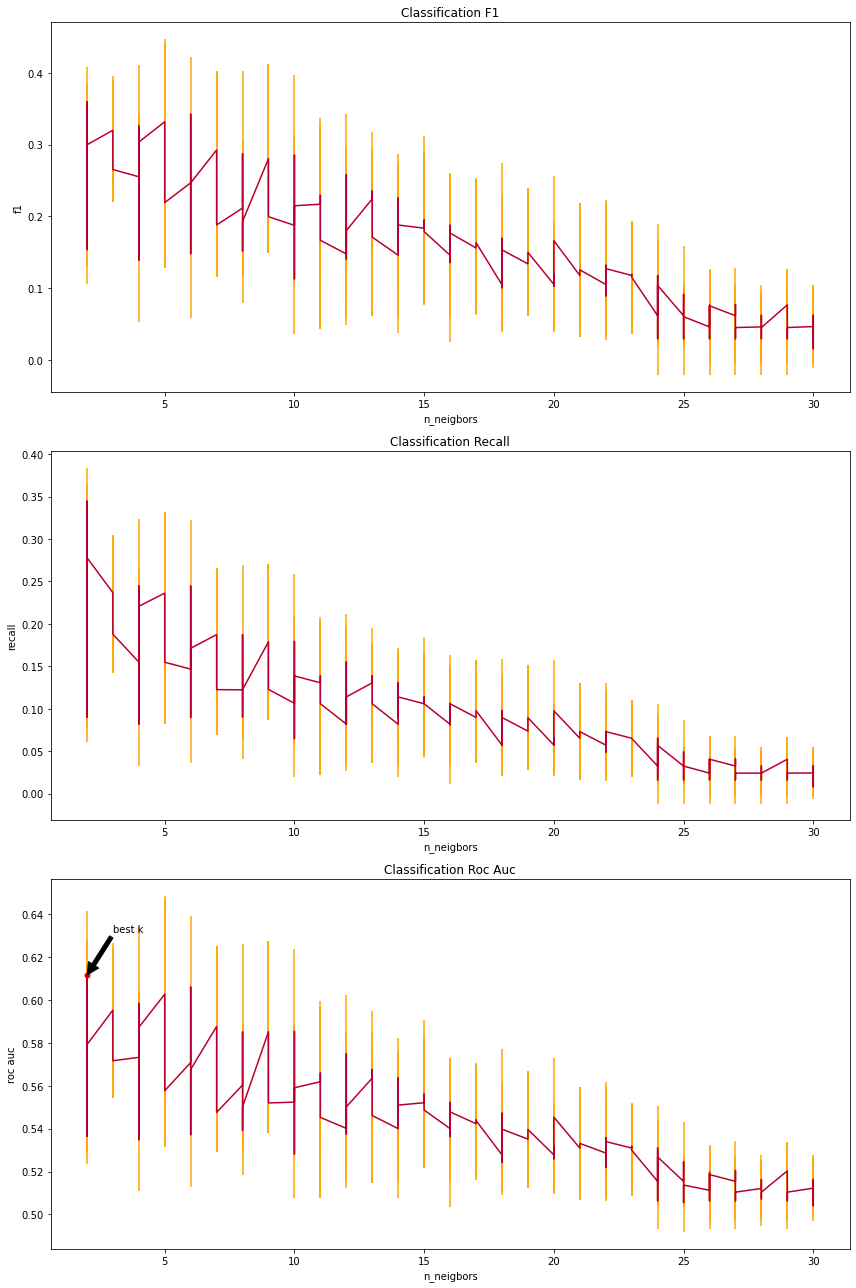



Permutation importances of the training set

Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

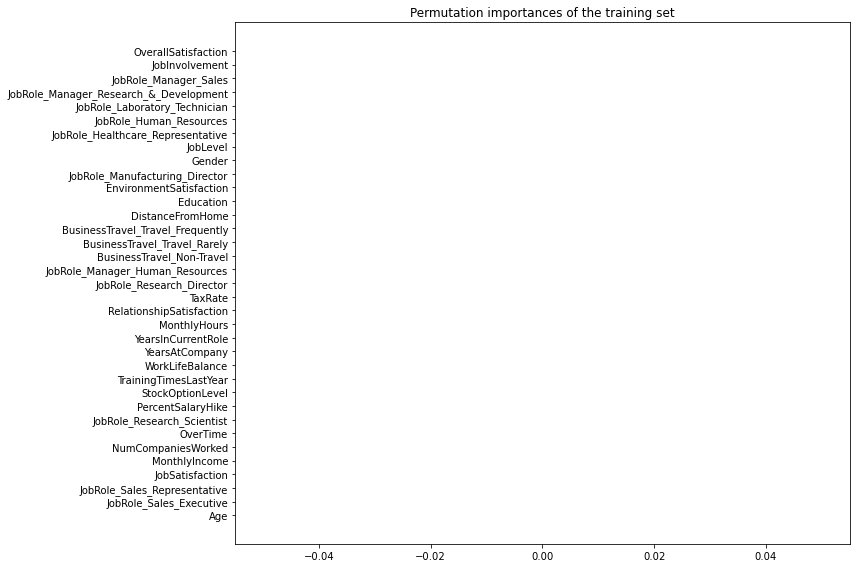



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.031606
OverTime                                           0.028325
JobRole_Sales_Representative                       0.020415
OverallSatisfaction                                0.017466
JobRole_Research_Scientist                         0.016803
JobRole_Manufacturing_Director                     0.014196
JobRole_Research_Director                          0.010981
RelationshipSatisfaction                           0.010948
YearsInCurrentRole                                 0.006441
WorkLifeBalance                                    0.004441
StockOptionLevel                                   0.003403
JobRole_Human_Resources                            0.002552
JobRole_Sales_Executive                            0.001668
JobLevel                                           0.001193
JobRole_Manager_Research_&_Development             0.001127
JobRole_Healthcare_Representative           

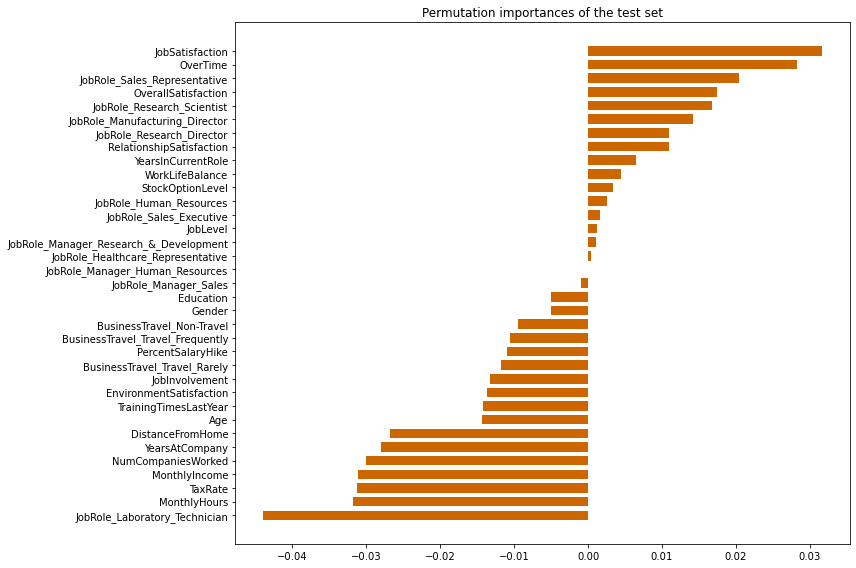



Confusion matrix


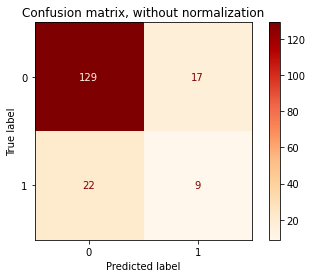

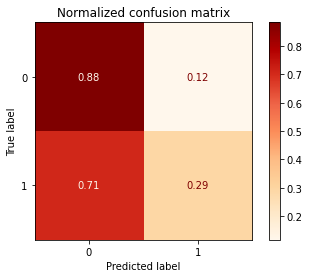


Classification report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       146
           1       0.35      0.29      0.32        31

    accuracy                           0.78       177
   macro avg       0.60      0.59      0.59       177
weighted avg       0.77      0.78      0.77       177


Metrics

Accuracy 0.7796610169491526
F1-score [0.86868687 0.31578947]
Precision [0.85430464 0.34615385]
Recall [0.88356164 0.29032258]
Roc_auc 0.5869421122403888


Roc curve



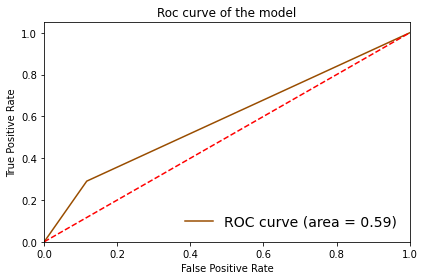


-------------------------------------------------------------------------------------------------------------



In [88]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [89]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.013651877133105802, 1.0],
   'tpr': [0.0, 0.11475409836065574, 1.0],
   'roc': 0.5505511106137749},
  '70-30': {'fpr': [0.0, 0.0410958904109589, 1.0],
   'tpr': [0.0, 0.21739130434782608, 1.0],
   'roc': 0.5881477069684337},
  '80-20': {'fpr': [0.0, 0.0958904109589041, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.5649580203269996}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.023890784982935155, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5782185419347619},
  '70-30': {'fpr': [0.0, 0.0228310502283105, 1.0],
   'tpr': [0.0, 0.17391304347826086, 1.0],
   'roc': 0.5755409966249752},
  '80-20': {'fpr': [0.0, 0.10273972602739725, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.561533362792753}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.04778156996587031, 1.0],
   'tpr': [0.0, 0.26229508196721313, 1.0],
   'roc': 0.6072567560006714},
  '70-30': {'fpr': [0.0, 0.0410958904109589, 1.0],
   'tpr': [0.0, 0.2

In [98]:
temporal_info = {}

In [99]:
model_name = '36f onehot-encoded kmeans discretized'
type_flag = 'validation'

In [100]:
temporal_info[type_flag] = {}
temporal_info[type_flag][model_name] = scaler_dict['RobustScaler']['60-40']
temporal_info

{'validation': {'36f onehot-encoded kmeans discretized': {'fpr': [0.0,
    0.04778156996587031,
    1.0],
   'tpr': [0.0, 0.26229508196721313, 1.0],
   'roc': 0.6072567560006714}}}

In [102]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['kmeans'] = temporal_info

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)